In [20]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
IMG_SIZE = 64 

In [12]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

In [14]:
train_dataset = torchvision.datasets.Flowers102(
    root='./data', 
    split='train',
    download=True, 
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

100%|██████████| 345M/345M [00:09<00:00, 36.4MB/s] 
100%|██████████| 502/502 [00:00<00:00, 1.73MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 25.4MB/s]


In [15]:
def show_images(images, title="Images"):
    images = images * 0.5 + 0.5  # Denormalize to [0, 1]
    images = torch.clamp(images, 0, 1)
    grid = torchvision.utils.make_grid(images[:16], nrow=4)
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(grid.cpu(), (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()


Batch shape: torch.Size([64, 3, 64, 64])


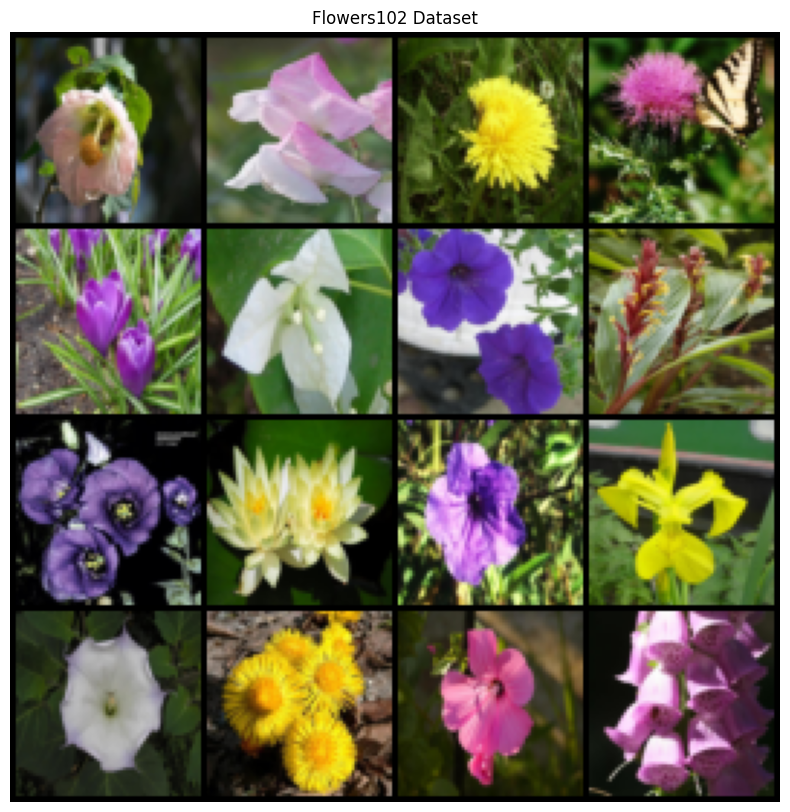

In [16]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(f"Batch shape: {images.shape}")
show_images(images, "Flowers102 Dataset")

In [17]:

T = 1000  # Total timesteps
beta_start = 0.0001
beta_end = 0.02

# Create a linear schedule of betas
betas = torch.linspace(beta_start, beta_end, T).to(device)

# Precompute useful values (these make the math much faster!)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = torch.cat([torch.tensor([1.0]).to(device), alphas_cumprod[:-1]])
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)

print(f"Beta at t=0: {betas[0]:.6f}")
print(f"Beta at t=500: {betas[500]:.6f}")
print(f"Beta at t=999: {betas[999]:.6f}")

Beta at t=0: 0.000100
Beta at t=500: 0.010060
Beta at t=999: 0.020000


In [18]:
def forward_diffusion(x0, t, noise=None):
    """
    Add noise to image x0 at timestep t
    
    Args:
        x0: Original image [batch_size, 3, H, W]
        t: Timestep (can be different for each image in batch) [batch_size]
        noise: Optional pre-generated noise (for reproducibility)
    
    Returns:
        Noisy image at timestep t
    """
    if noise is None:
        noise = torch.randn_like(x0)
    
    # Get the precomputed values for timestep t
    sqrt_alpha_cumprod_t = sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
    sqrt_one_minus_alpha_cumprod_t = sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
    
    # The formula: x_t = sqrt(alpha_cumprod_t) * x0 + sqrt(1 - alpha_cumprod_t) * noise
    return sqrt_alpha_cumprod_t * x0 + sqrt_one_minus_alpha_cumprod_t * noise

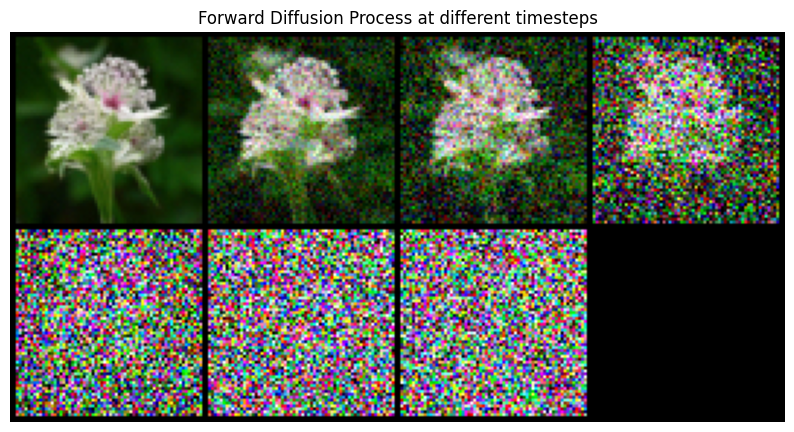

Timesteps shown: [0, 50, 100, 250, 500, 750, 999]


In [19]:
# Get a single image
dataiter = iter(train_loader)
images, _ = next(dataiter)
x0 = images[0:1].to(device)  # Take just one image

# Show the noising process at different timesteps
timesteps_to_show = [0, 50, 100, 250, 500, 750, 999]
noisy_images = []

for t in timesteps_to_show:
    t_tensor = torch.tensor([t]).to(device)
    noisy_img = forward_diffusion(x0, t_tensor)
    noisy_images.append(noisy_img.cpu())

# Visualize
noisy_images = torch.cat(noisy_images, dim=0)
show_images(noisy_images, f"Forward Diffusion Process at different timesteps")
print(f"Timesteps shown: {timesteps_to_show}")

In [21]:
class SinusoidalPositionEmbeddings(nn.Module):
    """Encodes timestep information for the network"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [25]:
class Block(nn.Module):
    """Basic convolutional block with GroupNorm"""
    def __init__(self, in_ch, out_ch, time_emb_dim, down=False, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        
        if up:
            self.conv1 = nn.Conv2d(2 * in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1) if down else nn.Identity()
        
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.GroupNorm(8, out_ch)
        self.bnorm2 = nn.GroupNorm(8, out_ch)
        self.relu = nn.ReLU()
        
    def forward(self, x, t):
        # First conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]  # Add spatial dimensions
        h = h + time_emb
        
        # Second conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        
        # Downsample or upsample
        return self.transform(h)

In [26]:
class SimpleUNet(nn.Module):
    """
    Simplified U-Net architecture for diffusion models
    """
    def __init__(self, img_channels=3, base_channels=64, time_emb_dim=256):
        super().__init__()
        
        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(base_channels),
            nn.Linear(base_channels, time_emb_dim),
            nn.ReLU()
        )
        
        # Initial projection
        self.conv0 = nn.Conv2d(img_channels, base_channels, 3, padding=1)
        
        # Encoder (downsampling)
        self.down1 = Block(base_channels, base_channels, time_emb_dim, down=True)
        self.down2 = Block(base_channels, base_channels * 2, time_emb_dim, down=True)
        self.down3 = Block(base_channels * 2, base_channels * 2, time_emb_dim, down=True)
        
        # Bottleneck (no downsampling)
        self.bot1 = Block(base_channels * 2, base_channels * 4, time_emb_dim)
        self.bot2 = Block(base_channels * 4, base_channels * 4, time_emb_dim)
        self.bot3 = Block(base_channels * 4, base_channels * 2, time_emb_dim)
        
        # Decoder (upsampling)
        self.up1 = Block(base_channels * 2, base_channels * 2, time_emb_dim, up=True)
        self.up2 = Block(base_channels * 2, base_channels, time_emb_dim, up=True)
        self.up3 = Block(base_channels, base_channels, time_emb_dim, up=True)
        
        # Output
        self.outc = nn.Conv2d(base_channels, img_channels, 1)
    
    def forward(self, x, timestep):
        # Embed time
        t = self.time_mlp(timestep)
        
        # Initial conv
        x = self.conv0(x)
        
        # Encoder with skip connections
        down1 = self.down1(x, t)  # 64x64 -> 32x32
        down2 = self.down2(down1, t)  # 32x32 -> 16x16
        down3 = self.down3(down2, t)  # 16x16 -> 8x8
        
        # Bottleneck (stays at 8x8)
        bot1 = self.bot1(down3, t)
        bot2 = self.bot2(bot1, t)
        bot3 = self.bot3(bot2, t)
        
        # Decoder with skip connections
        up1 = self.up1(torch.cat([bot3, down3], dim=1), t)  # 8x8 -> 16x16
        up2 = self.up2(torch.cat([up1, down2], dim=1), t)  # 16x16 -> 32x32
        up3 = self.up3(torch.cat([up2, down1], dim=1), t)  # 32x32 -> 64x64
        
        output = self.outc(up3)
        return output

In [27]:
# Recreate the model with the fix
model = SimpleUNet(img_channels=3, base_channels=64).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

# Test with a batch
test_images = images[:4].to(device)
test_timesteps = torch.randint(0, T, (4,)).to(device)

with torch.no_grad():
    noise_pred = model(test_images, test_timesteps)
    print(f"Input shape: {test_images.shape}")
    print(f"Output shape: {noise_pred.shape}")
    print(f"Timesteps: {test_timesteps}")

Total parameters: 5,155,907
Input shape: torch.Size([4, 3, 64, 64])
Output shape: torch.Size([4, 3, 64, 64])
Timesteps: tensor([183, 715, 186, 697], device='cuda:0')

✓ Model works correctly!


In [28]:
from torch.optim import Adam
from tqdm import tqdm

In [50]:
EPOCHS = 1000  # Start with 50, you can increase later
LEARNING_RATE = 2e-4

# Create optimizer
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

In [51]:
# Loss function - simple MSE between predicted and actual noise
def get_loss(model, x0, t):
    """
    Calculate the loss for a batch
    
    Args:
        model: The U-Net model
        x0: Clean images [batch_size, 3, H, W]
        t: Timesteps [batch_size]
    
    Returns:
        Loss value
    """
    # Generate random noise
    noise = torch.randn_like(x0)
    
    # Add noise to images (forward diffusion)
    x_noisy = forward_diffusion(x0, t, noise)
    
    # Predict the noise
    noise_pred = model(x_noisy, t)
    
    # Calculate loss (MSE between actual noise and predicted noise)
    loss = nn.functional.mse_loss(noise, noise_pred)
    
    return loss

In [52]:
# Training loop
print("Starting training...")
print(f"Device: {device}")
print(f"Dataset size: {len(train_dataset)}")
print(f"Batches per epoch: {len(train_loader)}")

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    
    # Progress bar
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    
    for batch_idx, (images, _) in enumerate(pbar):
        images = images.to(device)
        batch_size = images.shape[0]
        
        # Sample random timesteps for each image in the batch
        t = torch.randint(0, T, (batch_size,), device=device).long()
        
        # Calculate loss
        loss = get_loss(model, images, t)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track loss
        epoch_loss += loss.item()
        
        # Update progress bar
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # Print epoch summary
    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} - Average Loss: {avg_loss:.4f}")
    
    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, f'diffusion_model_epoch_{epoch+1}.pth')
        print(f"✓ Checkpoint saved at epoch {epoch+1}")

print("\n✓ Training complete!")

Starting training...
Device: cuda
Dataset size: 1020
Batches per epoch: 16


Epoch 1/1000: 100%|██████████| 16/16 [00:02<00:00,  6.38it/s, loss=0.0303]


Epoch 1/1000 - Average Loss: 0.0376


Epoch 2/1000: 100%|██████████| 16/16 [00:02<00:00,  6.79it/s, loss=0.0234]


Epoch 2/1000 - Average Loss: 0.0349


Epoch 3/1000: 100%|██████████| 16/16 [00:02<00:00,  6.49it/s, loss=0.0278]


Epoch 3/1000 - Average Loss: 0.0308


Epoch 4/1000: 100%|██████████| 16/16 [00:02<00:00,  6.14it/s, loss=0.0265]


Epoch 4/1000 - Average Loss: 0.0332


Epoch 5/1000: 100%|██████████| 16/16 [00:02<00:00,  6.03it/s, loss=0.0437]


Epoch 5/1000 - Average Loss: 0.0320


Epoch 6/1000: 100%|██████████| 16/16 [00:02<00:00,  6.57it/s, loss=0.0309]


Epoch 6/1000 - Average Loss: 0.0299


Epoch 7/1000: 100%|██████████| 16/16 [00:02<00:00,  6.56it/s, loss=0.0294]


Epoch 7/1000 - Average Loss: 0.0327


Epoch 8/1000: 100%|██████████| 16/16 [00:02<00:00,  6.14it/s, loss=0.0280]


Epoch 8/1000 - Average Loss: 0.0299


Epoch 9/1000: 100%|██████████| 16/16 [00:02<00:00,  6.21it/s, loss=0.0340]


Epoch 9/1000 - Average Loss: 0.0319


Epoch 10/1000: 100%|██████████| 16/16 [00:02<00:00,  6.65it/s, loss=0.0201]


Epoch 10/1000 - Average Loss: 0.0318
✓ Checkpoint saved at epoch 10


Epoch 11/1000: 100%|██████████| 16/16 [00:02<00:00,  6.52it/s, loss=0.0204]


Epoch 11/1000 - Average Loss: 0.0291


Epoch 12/1000: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s, loss=0.0377]


Epoch 12/1000 - Average Loss: 0.0316


Epoch 13/1000: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s, loss=0.0428]


Epoch 13/1000 - Average Loss: 0.0315


Epoch 14/1000: 100%|██████████| 16/16 [00:02<00:00,  6.58it/s, loss=0.0462]


Epoch 14/1000 - Average Loss: 0.0320


Epoch 15/1000: 100%|██████████| 16/16 [00:02<00:00,  6.20it/s, loss=0.0425]


Epoch 15/1000 - Average Loss: 0.0311


Epoch 16/1000: 100%|██████████| 16/16 [00:02<00:00,  6.24it/s, loss=0.0202]


Epoch 16/1000 - Average Loss: 0.0310


Epoch 17/1000: 100%|██████████| 16/16 [00:02<00:00,  6.35it/s, loss=0.0246]


Epoch 17/1000 - Average Loss: 0.0334


Epoch 18/1000: 100%|██████████| 16/16 [00:02<00:00,  6.31it/s, loss=0.0236]


Epoch 18/1000 - Average Loss: 0.0276


Epoch 19/1000: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s, loss=0.0289]


Epoch 19/1000 - Average Loss: 0.0319


Epoch 20/1000: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s, loss=0.0436]


Epoch 20/1000 - Average Loss: 0.0353
✓ Checkpoint saved at epoch 20


Epoch 21/1000: 100%|██████████| 16/16 [00:02<00:00,  6.36it/s, loss=0.0347]


Epoch 21/1000 - Average Loss: 0.0285


Epoch 22/1000: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s, loss=0.0485]


Epoch 22/1000 - Average Loss: 0.0344


Epoch 23/1000: 100%|██████████| 16/16 [00:02<00:00,  6.39it/s, loss=0.0307]


Epoch 23/1000 - Average Loss: 0.0296


Epoch 24/1000: 100%|██████████| 16/16 [00:02<00:00,  6.35it/s, loss=0.0253]


Epoch 24/1000 - Average Loss: 0.0323


Epoch 25/1000: 100%|██████████| 16/16 [00:02<00:00,  6.11it/s, loss=0.0251]


Epoch 25/1000 - Average Loss: 0.0315


Epoch 26/1000: 100%|██████████| 16/16 [00:02<00:00,  6.37it/s, loss=0.0417]


Epoch 26/1000 - Average Loss: 0.0355


Epoch 27/1000: 100%|██████████| 16/16 [00:02<00:00,  6.32it/s, loss=0.0691]


Epoch 27/1000 - Average Loss: 0.0360


Epoch 28/1000: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s, loss=0.0207]


Epoch 28/1000 - Average Loss: 0.0330


Epoch 29/1000: 100%|██████████| 16/16 [00:02<00:00,  6.17it/s, loss=0.0299]


Epoch 29/1000 - Average Loss: 0.0303


Epoch 30/1000: 100%|██████████| 16/16 [00:02<00:00,  6.27it/s, loss=0.0468]


Epoch 30/1000 - Average Loss: 0.0318
✓ Checkpoint saved at epoch 30


Epoch 31/1000: 100%|██████████| 16/16 [00:02<00:00,  6.35it/s, loss=0.0502]


Epoch 31/1000 - Average Loss: 0.0374


Epoch 32/1000: 100%|██████████| 16/16 [00:02<00:00,  6.26it/s, loss=0.0328]


Epoch 32/1000 - Average Loss: 0.0363


Epoch 33/1000: 100%|██████████| 16/16 [00:02<00:00,  6.25it/s, loss=0.0217]


Epoch 33/1000 - Average Loss: 0.0305


Epoch 34/1000: 100%|██████████| 16/16 [00:02<00:00,  6.58it/s, loss=0.0316]


Epoch 34/1000 - Average Loss: 0.0295


Epoch 35/1000: 100%|██████████| 16/16 [00:02<00:00,  6.26it/s, loss=0.0245]


Epoch 35/1000 - Average Loss: 0.0325


Epoch 36/1000: 100%|██████████| 16/16 [00:02<00:00,  6.61it/s, loss=0.0266]


Epoch 36/1000 - Average Loss: 0.0296


Epoch 37/1000: 100%|██████████| 16/16 [00:02<00:00,  6.60it/s, loss=0.0536]


Epoch 37/1000 - Average Loss: 0.0319


Epoch 38/1000: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s, loss=0.0236]


Epoch 38/1000 - Average Loss: 0.0349


Epoch 39/1000: 100%|██████████| 16/16 [00:02<00:00,  6.40it/s, loss=0.0394]


Epoch 39/1000 - Average Loss: 0.0306


Epoch 40/1000: 100%|██████████| 16/16 [00:02<00:00,  6.52it/s, loss=0.0400]


Epoch 40/1000 - Average Loss: 0.0358
✓ Checkpoint saved at epoch 40


Epoch 41/1000: 100%|██████████| 16/16 [00:02<00:00,  6.58it/s, loss=0.0254]


Epoch 41/1000 - Average Loss: 0.0337


Epoch 42/1000: 100%|██████████| 16/16 [00:02<00:00,  6.19it/s, loss=0.0350]


Epoch 42/1000 - Average Loss: 0.0364


Epoch 43/1000: 100%|██████████| 16/16 [00:02<00:00,  6.59it/s, loss=0.0332]


Epoch 43/1000 - Average Loss: 0.0299


Epoch 44/1000: 100%|██████████| 16/16 [00:02<00:00,  6.31it/s, loss=0.0425]


Epoch 44/1000 - Average Loss: 0.0282


Epoch 45/1000: 100%|██████████| 16/16 [00:02<00:00,  6.39it/s, loss=0.0336]


Epoch 45/1000 - Average Loss: 0.0328


Epoch 46/1000: 100%|██████████| 16/16 [00:02<00:00,  6.50it/s, loss=0.0199]


Epoch 46/1000 - Average Loss: 0.0307


Epoch 47/1000: 100%|██████████| 16/16 [00:02<00:00,  6.40it/s, loss=0.0412]


Epoch 47/1000 - Average Loss: 0.0320


Epoch 48/1000: 100%|██████████| 16/16 [00:02<00:00,  6.48it/s, loss=0.0333]


Epoch 48/1000 - Average Loss: 0.0277


Epoch 49/1000: 100%|██████████| 16/16 [00:02<00:00,  6.19it/s, loss=0.0300]


Epoch 49/1000 - Average Loss: 0.0334


Epoch 50/1000: 100%|██████████| 16/16 [00:02<00:00,  6.37it/s, loss=0.0205]


Epoch 50/1000 - Average Loss: 0.0349
✓ Checkpoint saved at epoch 50


Epoch 51/1000: 100%|██████████| 16/16 [00:02<00:00,  6.26it/s, loss=0.0486]


Epoch 51/1000 - Average Loss: 0.0324


Epoch 52/1000: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s, loss=0.0460]


Epoch 52/1000 - Average Loss: 0.0311


Epoch 53/1000: 100%|██████████| 16/16 [00:02<00:00,  6.49it/s, loss=0.0284]


Epoch 53/1000 - Average Loss: 0.0307


Epoch 54/1000: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s, loss=0.0282]


Epoch 54/1000 - Average Loss: 0.0311


Epoch 55/1000: 100%|██████████| 16/16 [00:02<00:00,  6.53it/s, loss=0.0446]


Epoch 55/1000 - Average Loss: 0.0333


Epoch 56/1000: 100%|██████████| 16/16 [00:02<00:00,  6.56it/s, loss=0.0348]


Epoch 56/1000 - Average Loss: 0.0329


Epoch 57/1000: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s, loss=0.0134]


Epoch 57/1000 - Average Loss: 0.0283


Epoch 58/1000: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s, loss=0.0491]


Epoch 58/1000 - Average Loss: 0.0316


Epoch 59/1000: 100%|██████████| 16/16 [00:02<00:00,  6.36it/s, loss=0.0400]


Epoch 59/1000 - Average Loss: 0.0368


Epoch 60/1000: 100%|██████████| 16/16 [00:02<00:00,  6.56it/s, loss=0.0193]


Epoch 60/1000 - Average Loss: 0.0320
✓ Checkpoint saved at epoch 60


Epoch 61/1000: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s, loss=0.0237]


Epoch 61/1000 - Average Loss: 0.0296


Epoch 62/1000: 100%|██████████| 16/16 [00:02<00:00,  6.48it/s, loss=0.0197]


Epoch 62/1000 - Average Loss: 0.0304


Epoch 63/1000: 100%|██████████| 16/16 [00:02<00:00,  6.09it/s, loss=0.0293]


Epoch 63/1000 - Average Loss: 0.0336


Epoch 64/1000: 100%|██████████| 16/16 [00:02<00:00,  6.33it/s, loss=0.0449]


Epoch 64/1000 - Average Loss: 0.0363


Epoch 65/1000: 100%|██████████| 16/16 [00:02<00:00,  6.43it/s, loss=0.0322]


Epoch 65/1000 - Average Loss: 0.0327


Epoch 66/1000: 100%|██████████| 16/16 [00:02<00:00,  6.63it/s, loss=0.0454]


Epoch 66/1000 - Average Loss: 0.0314


Epoch 67/1000: 100%|██████████| 16/16 [00:02<00:00,  6.42it/s, loss=0.0430]


Epoch 67/1000 - Average Loss: 0.0348


Epoch 68/1000: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s, loss=0.0114]


Epoch 68/1000 - Average Loss: 0.0325


Epoch 69/1000: 100%|██████████| 16/16 [00:02<00:00,  6.59it/s, loss=0.0296]


Epoch 69/1000 - Average Loss: 0.0301


Epoch 70/1000: 100%|██████████| 16/16 [00:02<00:00,  6.31it/s, loss=0.0184]


Epoch 70/1000 - Average Loss: 0.0301
✓ Checkpoint saved at epoch 70


Epoch 71/1000: 100%|██████████| 16/16 [00:02<00:00,  6.07it/s, loss=0.0326]


Epoch 71/1000 - Average Loss: 0.0311


Epoch 72/1000: 100%|██████████| 16/16 [00:02<00:00,  6.34it/s, loss=0.0207]


Epoch 72/1000 - Average Loss: 0.0295


Epoch 73/1000: 100%|██████████| 16/16 [00:02<00:00,  6.54it/s, loss=0.0339]


Epoch 73/1000 - Average Loss: 0.0304


Epoch 74/1000: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s, loss=0.0239]


Epoch 74/1000 - Average Loss: 0.0334


Epoch 75/1000: 100%|██████████| 16/16 [00:02<00:00,  6.24it/s, loss=0.0299]


Epoch 75/1000 - Average Loss: 0.0292


Epoch 76/1000: 100%|██████████| 16/16 [00:02<00:00,  6.21it/s, loss=0.0242]


Epoch 76/1000 - Average Loss: 0.0292


Epoch 77/1000: 100%|██████████| 16/16 [00:02<00:00,  6.39it/s, loss=0.0175]


Epoch 77/1000 - Average Loss: 0.0298


Epoch 78/1000: 100%|██████████| 16/16 [00:02<00:00,  6.56it/s, loss=0.0314]


Epoch 78/1000 - Average Loss: 0.0338


Epoch 79/1000: 100%|██████████| 16/16 [00:02<00:00,  6.27it/s, loss=0.0292]


Epoch 79/1000 - Average Loss: 0.0347


Epoch 80/1000: 100%|██████████| 16/16 [00:02<00:00,  6.57it/s, loss=0.0392]


Epoch 80/1000 - Average Loss: 0.0347
✓ Checkpoint saved at epoch 80


Epoch 81/1000: 100%|██████████| 16/16 [00:02<00:00,  6.54it/s, loss=0.0225]


Epoch 81/1000 - Average Loss: 0.0296


Epoch 82/1000: 100%|██████████| 16/16 [00:02<00:00,  6.33it/s, loss=0.0402]


Epoch 82/1000 - Average Loss: 0.0333


Epoch 83/1000: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s, loss=0.0276]


Epoch 83/1000 - Average Loss: 0.0316


Epoch 84/1000: 100%|██████████| 16/16 [00:02<00:00,  6.40it/s, loss=0.0374]


Epoch 84/1000 - Average Loss: 0.0348


Epoch 85/1000: 100%|██████████| 16/16 [00:02<00:00,  6.05it/s, loss=0.0357]


Epoch 85/1000 - Average Loss: 0.0355


Epoch 86/1000: 100%|██████████| 16/16 [00:02<00:00,  6.49it/s, loss=0.0272]


Epoch 86/1000 - Average Loss: 0.0329


Epoch 87/1000: 100%|██████████| 16/16 [00:02<00:00,  6.40it/s, loss=0.0247]


Epoch 87/1000 - Average Loss: 0.0326


Epoch 88/1000: 100%|██████████| 16/16 [00:02<00:00,  6.50it/s, loss=0.0254]


Epoch 88/1000 - Average Loss: 0.0347


Epoch 89/1000: 100%|██████████| 16/16 [00:02<00:00,  6.58it/s, loss=0.0373]


Epoch 89/1000 - Average Loss: 0.0323


Epoch 90/1000: 100%|██████████| 16/16 [00:02<00:00,  6.49it/s, loss=0.0324]


Epoch 90/1000 - Average Loss: 0.0332
✓ Checkpoint saved at epoch 90


Epoch 91/1000: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s, loss=0.0246]


Epoch 91/1000 - Average Loss: 0.0289


Epoch 92/1000: 100%|██████████| 16/16 [00:02<00:00,  6.42it/s, loss=0.0189]


Epoch 92/1000 - Average Loss: 0.0313


Epoch 93/1000: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s, loss=0.0170]


Epoch 93/1000 - Average Loss: 0.0328


Epoch 94/1000: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s, loss=0.0298]


Epoch 94/1000 - Average Loss: 0.0296


Epoch 95/1000: 100%|██████████| 16/16 [00:02<00:00,  6.19it/s, loss=0.0452]


Epoch 95/1000 - Average Loss: 0.0363


Epoch 96/1000: 100%|██████████| 16/16 [00:02<00:00,  6.40it/s, loss=0.0345]


Epoch 96/1000 - Average Loss: 0.0336


Epoch 97/1000: 100%|██████████| 16/16 [00:02<00:00,  6.38it/s, loss=0.0237]


Epoch 97/1000 - Average Loss: 0.0341


Epoch 98/1000: 100%|██████████| 16/16 [00:02<00:00,  6.30it/s, loss=0.0336]


Epoch 98/1000 - Average Loss: 0.0283


Epoch 99/1000: 100%|██████████| 16/16 [00:02<00:00,  6.33it/s, loss=0.0231]


Epoch 99/1000 - Average Loss: 0.0339


Epoch 100/1000: 100%|██████████| 16/16 [00:02<00:00,  6.49it/s, loss=0.0334]


Epoch 100/1000 - Average Loss: 0.0362
✓ Checkpoint saved at epoch 100


Epoch 101/1000: 100%|██████████| 16/16 [00:02<00:00,  6.19it/s, loss=0.0205]


Epoch 101/1000 - Average Loss: 0.0319


Epoch 102/1000: 100%|██████████| 16/16 [00:02<00:00,  6.27it/s, loss=0.0283]


Epoch 102/1000 - Average Loss: 0.0309


Epoch 103/1000: 100%|██████████| 16/16 [00:02<00:00,  6.26it/s, loss=0.0312]


Epoch 103/1000 - Average Loss: 0.0328


Epoch 104/1000: 100%|██████████| 16/16 [00:02<00:00,  6.40it/s, loss=0.0338]


Epoch 104/1000 - Average Loss: 0.0317


Epoch 105/1000: 100%|██████████| 16/16 [00:02<00:00,  6.34it/s, loss=0.0351]


Epoch 105/1000 - Average Loss: 0.0302


Epoch 106/1000: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s, loss=0.0408]


Epoch 106/1000 - Average Loss: 0.0309


Epoch 107/1000: 100%|██████████| 16/16 [00:02<00:00,  6.49it/s, loss=0.0145]


Epoch 107/1000 - Average Loss: 0.0313


Epoch 108/1000: 100%|██████████| 16/16 [00:02<00:00,  6.31it/s, loss=0.0360]


Epoch 108/1000 - Average Loss: 0.0323


Epoch 109/1000: 100%|██████████| 16/16 [00:02<00:00,  6.26it/s, loss=0.0370]


Epoch 109/1000 - Average Loss: 0.0271


Epoch 110/1000: 100%|██████████| 16/16 [00:02<00:00,  6.35it/s, loss=0.0457]


Epoch 110/1000 - Average Loss: 0.0271
✓ Checkpoint saved at epoch 110


Epoch 111/1000: 100%|██████████| 16/16 [00:02<00:00,  6.33it/s, loss=0.0270]


Epoch 111/1000 - Average Loss: 0.0250


Epoch 112/1000: 100%|██████████| 16/16 [00:02<00:00,  6.21it/s, loss=0.0364]


Epoch 112/1000 - Average Loss: 0.0299


Epoch 113/1000: 100%|██████████| 16/16 [00:02<00:00,  6.35it/s, loss=0.0209]


Epoch 113/1000 - Average Loss: 0.0327


Epoch 114/1000: 100%|██████████| 16/16 [00:02<00:00,  6.35it/s, loss=0.0273]


Epoch 114/1000 - Average Loss: 0.0309


Epoch 115/1000: 100%|██████████| 16/16 [00:02<00:00,  6.36it/s, loss=0.0518]


Epoch 115/1000 - Average Loss: 0.0326


Epoch 116/1000: 100%|██████████| 16/16 [00:02<00:00,  6.20it/s, loss=0.0219]


Epoch 116/1000 - Average Loss: 0.0280


Epoch 117/1000: 100%|██████████| 16/16 [00:02<00:00,  6.49it/s, loss=0.0275]


Epoch 117/1000 - Average Loss: 0.0312


Epoch 118/1000: 100%|██████████| 16/16 [00:02<00:00,  6.48it/s, loss=0.0343]


Epoch 118/1000 - Average Loss: 0.0310


Epoch 119/1000: 100%|██████████| 16/16 [00:02<00:00,  6.39it/s, loss=0.0347]


Epoch 119/1000 - Average Loss: 0.0274


Epoch 120/1000: 100%|██████████| 16/16 [00:02<00:00,  6.32it/s, loss=0.0230]


Epoch 120/1000 - Average Loss: 0.0330
✓ Checkpoint saved at epoch 120


Epoch 121/1000: 100%|██████████| 16/16 [00:02<00:00,  6.35it/s, loss=0.0316]


Epoch 121/1000 - Average Loss: 0.0339


Epoch 122/1000: 100%|██████████| 16/16 [00:02<00:00,  6.48it/s, loss=0.0470]


Epoch 122/1000 - Average Loss: 0.0379


Epoch 123/1000: 100%|██████████| 16/16 [00:02<00:00,  6.57it/s, loss=0.0171]


Epoch 123/1000 - Average Loss: 0.0301


Epoch 124/1000: 100%|██████████| 16/16 [00:02<00:00,  6.34it/s, loss=0.0273]


Epoch 124/1000 - Average Loss: 0.0330


Epoch 125/1000: 100%|██████████| 16/16 [00:02<00:00,  6.32it/s, loss=0.0398]


Epoch 125/1000 - Average Loss: 0.0371


Epoch 126/1000: 100%|██████████| 16/16 [00:02<00:00,  6.29it/s, loss=0.0342]


Epoch 126/1000 - Average Loss: 0.0330


Epoch 127/1000: 100%|██████████| 16/16 [00:02<00:00,  6.51it/s, loss=0.0311]


Epoch 127/1000 - Average Loss: 0.0278


Epoch 128/1000: 100%|██████████| 16/16 [00:02<00:00,  6.25it/s, loss=0.0388]


Epoch 128/1000 - Average Loss: 0.0337


Epoch 129/1000: 100%|██████████| 16/16 [00:02<00:00,  6.32it/s, loss=0.0321]


Epoch 129/1000 - Average Loss: 0.0278


Epoch 130/1000: 100%|██████████| 16/16 [00:02<00:00,  6.60it/s, loss=0.0200]


Epoch 130/1000 - Average Loss: 0.0284
✓ Checkpoint saved at epoch 130


Epoch 131/1000: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s, loss=0.0257]


Epoch 131/1000 - Average Loss: 0.0295


Epoch 132/1000: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s, loss=0.0369]


Epoch 132/1000 - Average Loss: 0.0332


Epoch 133/1000: 100%|██████████| 16/16 [00:02<00:00,  6.34it/s, loss=0.0260]


Epoch 133/1000 - Average Loss: 0.0257


Epoch 134/1000: 100%|██████████| 16/16 [00:02<00:00,  6.57it/s, loss=0.0189]


Epoch 134/1000 - Average Loss: 0.0310


Epoch 135/1000: 100%|██████████| 16/16 [00:02<00:00,  6.60it/s, loss=0.0288]


Epoch 135/1000 - Average Loss: 0.0300


Epoch 136/1000: 100%|██████████| 16/16 [00:02<00:00,  6.36it/s, loss=0.0318]


Epoch 136/1000 - Average Loss: 0.0310


Epoch 137/1000: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s, loss=0.0189]


Epoch 137/1000 - Average Loss: 0.0313


Epoch 138/1000: 100%|██████████| 16/16 [00:02<00:00,  6.57it/s, loss=0.0332]


Epoch 138/1000 - Average Loss: 0.0303


Epoch 139/1000: 100%|██████████| 16/16 [00:02<00:00,  6.56it/s, loss=0.0484]


Epoch 139/1000 - Average Loss: 0.0302


Epoch 140/1000: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s, loss=0.0358]


Epoch 140/1000 - Average Loss: 0.0322
✓ Checkpoint saved at epoch 140


Epoch 141/1000: 100%|██████████| 16/16 [00:02<00:00,  6.35it/s, loss=0.0200]


Epoch 141/1000 - Average Loss: 0.0294


Epoch 142/1000: 100%|██████████| 16/16 [00:02<00:00,  6.17it/s, loss=0.0224]


Epoch 142/1000 - Average Loss: 0.0318


Epoch 143/1000: 100%|██████████| 16/16 [00:02<00:00,  6.59it/s, loss=0.0166]


Epoch 143/1000 - Average Loss: 0.0321


Epoch 144/1000: 100%|██████████| 16/16 [00:02<00:00,  6.21it/s, loss=0.0343]


Epoch 144/1000 - Average Loss: 0.0288


Epoch 145/1000: 100%|██████████| 16/16 [00:02<00:00,  6.57it/s, loss=0.0411]


Epoch 145/1000 - Average Loss: 0.0350


Epoch 146/1000: 100%|██████████| 16/16 [00:02<00:00,  6.52it/s, loss=0.0478]


Epoch 146/1000 - Average Loss: 0.0277


Epoch 147/1000: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s, loss=0.0307]


Epoch 147/1000 - Average Loss: 0.0310


Epoch 148/1000: 100%|██████████| 16/16 [00:02<00:00,  6.43it/s, loss=0.0319]


Epoch 148/1000 - Average Loss: 0.0338


Epoch 149/1000: 100%|██████████| 16/16 [00:02<00:00,  6.26it/s, loss=0.0212]


Epoch 149/1000 - Average Loss: 0.0312


Epoch 150/1000: 100%|██████████| 16/16 [00:02<00:00,  6.53it/s, loss=0.0463]


Epoch 150/1000 - Average Loss: 0.0348
✓ Checkpoint saved at epoch 150


Epoch 151/1000: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s, loss=0.0388]


Epoch 151/1000 - Average Loss: 0.0296


Epoch 152/1000: 100%|██████████| 16/16 [00:02<00:00,  6.38it/s, loss=0.0244]


Epoch 152/1000 - Average Loss: 0.0295


Epoch 153/1000: 100%|██████████| 16/16 [00:02<00:00,  6.35it/s, loss=0.0352]


Epoch 153/1000 - Average Loss: 0.0297


Epoch 154/1000: 100%|██████████| 16/16 [00:02<00:00,  6.49it/s, loss=0.0201]


Epoch 154/1000 - Average Loss: 0.0269


Epoch 155/1000: 100%|██████████| 16/16 [00:02<00:00,  6.56it/s, loss=0.0419]


Epoch 155/1000 - Average Loss: 0.0295


Epoch 156/1000: 100%|██████████| 16/16 [00:02<00:00,  6.39it/s, loss=0.0400]


Epoch 156/1000 - Average Loss: 0.0287


Epoch 157/1000: 100%|██████████| 16/16 [00:02<00:00,  6.33it/s, loss=0.0435]


Epoch 157/1000 - Average Loss: 0.0309


Epoch 158/1000: 100%|██████████| 16/16 [00:02<00:00,  6.56it/s, loss=0.0417]


Epoch 158/1000 - Average Loss: 0.0323


Epoch 159/1000: 100%|██████████| 16/16 [00:02<00:00,  6.57it/s, loss=0.0110]


Epoch 159/1000 - Average Loss: 0.0298


Epoch 160/1000: 100%|██████████| 16/16 [00:02<00:00,  6.51it/s, loss=0.0220]


Epoch 160/1000 - Average Loss: 0.0329
✓ Checkpoint saved at epoch 160


Epoch 161/1000: 100%|██████████| 16/16 [00:02<00:00,  6.30it/s, loss=0.0450]


Epoch 161/1000 - Average Loss: 0.0324


Epoch 162/1000: 100%|██████████| 16/16 [00:02<00:00,  6.35it/s, loss=0.0476]


Epoch 162/1000 - Average Loss: 0.0281


Epoch 163/1000: 100%|██████████| 16/16 [00:02<00:00,  6.58it/s, loss=0.0136]


Epoch 163/1000 - Average Loss: 0.0297


Epoch 164/1000: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s, loss=0.0376]


Epoch 164/1000 - Average Loss: 0.0333


Epoch 165/1000: 100%|██████████| 16/16 [00:02<00:00,  6.57it/s, loss=0.0307]


Epoch 165/1000 - Average Loss: 0.0297


Epoch 166/1000: 100%|██████████| 16/16 [00:02<00:00,  6.55it/s, loss=0.0302]


Epoch 166/1000 - Average Loss: 0.0337


Epoch 167/1000: 100%|██████████| 16/16 [00:02<00:00,  6.39it/s, loss=0.0345]


Epoch 167/1000 - Average Loss: 0.0361


Epoch 168/1000: 100%|██████████| 16/16 [00:02<00:00,  6.11it/s, loss=0.0141]


Epoch 168/1000 - Average Loss: 0.0253


Epoch 169/1000: 100%|██████████| 16/16 [00:02<00:00,  6.53it/s, loss=0.0365]


Epoch 169/1000 - Average Loss: 0.0325


Epoch 170/1000: 100%|██████████| 16/16 [00:02<00:00,  6.51it/s, loss=0.0237]


Epoch 170/1000 - Average Loss: 0.0301
✓ Checkpoint saved at epoch 170


Epoch 171/1000: 100%|██████████| 16/16 [00:02<00:00,  6.53it/s, loss=0.0210]


Epoch 171/1000 - Average Loss: 0.0308


Epoch 172/1000: 100%|██████████| 16/16 [00:02<00:00,  6.37it/s, loss=0.0364]


Epoch 172/1000 - Average Loss: 0.0310


Epoch 173/1000: 100%|██████████| 16/16 [00:02<00:00,  6.40it/s, loss=0.0368]


Epoch 173/1000 - Average Loss: 0.0300


Epoch 174/1000: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s, loss=0.0425]


Epoch 174/1000 - Average Loss: 0.0300


Epoch 175/1000: 100%|██████████| 16/16 [00:02<00:00,  6.42it/s, loss=0.0192]


Epoch 175/1000 - Average Loss: 0.0277


Epoch 176/1000: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s, loss=0.0234]


Epoch 176/1000 - Average Loss: 0.0292


Epoch 177/1000: 100%|██████████| 16/16 [00:02<00:00,  6.28it/s, loss=0.0380]


Epoch 177/1000 - Average Loss: 0.0350


Epoch 178/1000: 100%|██████████| 16/16 [00:02<00:00,  6.23it/s, loss=0.0368]


Epoch 178/1000 - Average Loss: 0.0297


Epoch 179/1000: 100%|██████████| 16/16 [00:02<00:00,  6.55it/s, loss=0.0450]


Epoch 179/1000 - Average Loss: 0.0316


Epoch 180/1000: 100%|██████████| 16/16 [00:02<00:00,  6.56it/s, loss=0.0366]


Epoch 180/1000 - Average Loss: 0.0302
✓ Checkpoint saved at epoch 180


Epoch 181/1000: 100%|██████████| 16/16 [00:02<00:00,  6.48it/s, loss=0.0326]


Epoch 181/1000 - Average Loss: 0.0306


Epoch 182/1000: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s, loss=0.0390]


Epoch 182/1000 - Average Loss: 0.0297


Epoch 183/1000: 100%|██████████| 16/16 [00:02<00:00,  6.58it/s, loss=0.0364]


Epoch 183/1000 - Average Loss: 0.0313


Epoch 184/1000: 100%|██████████| 16/16 [00:02<00:00,  6.30it/s, loss=0.0366]


Epoch 184/1000 - Average Loss: 0.0324


Epoch 185/1000: 100%|██████████| 16/16 [00:02<00:00,  6.33it/s, loss=0.0307]


Epoch 185/1000 - Average Loss: 0.0318


Epoch 186/1000: 100%|██████████| 16/16 [00:02<00:00,  6.39it/s, loss=0.0436]


Epoch 186/1000 - Average Loss: 0.0353


Epoch 187/1000: 100%|██████████| 16/16 [00:02<00:00,  6.37it/s, loss=0.0197]


Epoch 187/1000 - Average Loss: 0.0285


Epoch 188/1000: 100%|██████████| 16/16 [00:02<00:00,  6.40it/s, loss=0.0226]


Epoch 188/1000 - Average Loss: 0.0292


Epoch 189/1000: 100%|██████████| 16/16 [00:02<00:00,  6.51it/s, loss=0.0272]


Epoch 189/1000 - Average Loss: 0.0280


Epoch 190/1000: 100%|██████████| 16/16 [00:02<00:00,  6.15it/s, loss=0.0378]


Epoch 190/1000 - Average Loss: 0.0316
✓ Checkpoint saved at epoch 190


Epoch 191/1000: 100%|██████████| 16/16 [00:02<00:00,  6.51it/s, loss=0.0415]


Epoch 191/1000 - Average Loss: 0.0284


Epoch 192/1000: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s, loss=0.0298]


Epoch 192/1000 - Average Loss: 0.0328


Epoch 193/1000: 100%|██████████| 16/16 [00:02<00:00,  6.30it/s, loss=0.0267]


Epoch 193/1000 - Average Loss: 0.0338


Epoch 194/1000: 100%|██████████| 16/16 [00:02<00:00,  6.32it/s, loss=0.0183]


Epoch 194/1000 - Average Loss: 0.0280


Epoch 195/1000: 100%|██████████| 16/16 [00:02<00:00,  6.48it/s, loss=0.0239]


Epoch 195/1000 - Average Loss: 0.0327


Epoch 196/1000: 100%|██████████| 16/16 [00:02<00:00,  6.40it/s, loss=0.0219]


Epoch 196/1000 - Average Loss: 0.0293


Epoch 197/1000: 100%|██████████| 16/16 [00:02<00:00,  6.53it/s, loss=0.0261]


Epoch 197/1000 - Average Loss: 0.0280


Epoch 198/1000: 100%|██████████| 16/16 [00:02<00:00,  6.43it/s, loss=0.0216]


Epoch 198/1000 - Average Loss: 0.0312


Epoch 199/1000: 100%|██████████| 16/16 [00:02<00:00,  6.45it/s, loss=0.0178]


Epoch 199/1000 - Average Loss: 0.0316


Epoch 200/1000: 100%|██████████| 16/16 [00:02<00:00,  6.59it/s, loss=0.0285]


Epoch 200/1000 - Average Loss: 0.0317
✓ Checkpoint saved at epoch 200


Epoch 201/1000: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s, loss=0.0290]


Epoch 201/1000 - Average Loss: 0.0296


Epoch 202/1000: 100%|██████████| 16/16 [00:02<00:00,  5.96it/s, loss=0.0234]


Epoch 202/1000 - Average Loss: 0.0310


Epoch 203/1000: 100%|██████████| 16/16 [00:02<00:00,  6.16it/s, loss=0.0220]


Epoch 203/1000 - Average Loss: 0.0300


Epoch 204/1000: 100%|██████████| 16/16 [00:02<00:00,  6.37it/s, loss=0.0437]


Epoch 204/1000 - Average Loss: 0.0353


Epoch 205/1000: 100%|██████████| 16/16 [00:02<00:00,  6.36it/s, loss=0.0338]


Epoch 205/1000 - Average Loss: 0.0350


Epoch 206/1000: 100%|██████████| 16/16 [00:02<00:00,  6.13it/s, loss=0.0244]


Epoch 206/1000 - Average Loss: 0.0332


Epoch 207/1000: 100%|██████████| 16/16 [00:02<00:00,  6.49it/s, loss=0.0386]


Epoch 207/1000 - Average Loss: 0.0369


Epoch 208/1000: 100%|██████████| 16/16 [00:02<00:00,  6.24it/s, loss=0.0203]


Epoch 208/1000 - Average Loss: 0.0299


Epoch 209/1000: 100%|██████████| 16/16 [00:02<00:00,  6.52it/s, loss=0.0189]


Epoch 209/1000 - Average Loss: 0.0347


Epoch 210/1000: 100%|██████████| 16/16 [00:02<00:00,  6.55it/s, loss=0.0376]


Epoch 210/1000 - Average Loss: 0.0278
✓ Checkpoint saved at epoch 210


Epoch 211/1000: 100%|██████████| 16/16 [00:02<00:00,  6.53it/s, loss=0.0302]


Epoch 211/1000 - Average Loss: 0.0307


Epoch 212/1000: 100%|██████████| 16/16 [00:02<00:00,  6.52it/s, loss=0.0162]


Epoch 212/1000 - Average Loss: 0.0282


Epoch 213/1000: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s, loss=0.0233]


Epoch 213/1000 - Average Loss: 0.0330


Epoch 214/1000: 100%|██████████| 16/16 [00:02<00:00,  6.38it/s, loss=0.0479]


Epoch 214/1000 - Average Loss: 0.0321


Epoch 215/1000: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s, loss=0.0313]


Epoch 215/1000 - Average Loss: 0.0285


Epoch 216/1000: 100%|██████████| 16/16 [00:02<00:00,  6.36it/s, loss=0.0422]


Epoch 216/1000 - Average Loss: 0.0322


Epoch 217/1000: 100%|██████████| 16/16 [00:02<00:00,  6.23it/s, loss=0.0249]


Epoch 217/1000 - Average Loss: 0.0315


Epoch 218/1000: 100%|██████████| 16/16 [00:02<00:00,  6.39it/s, loss=0.0453]


Epoch 218/1000 - Average Loss: 0.0344


Epoch 219/1000: 100%|██████████| 16/16 [00:02<00:00,  6.35it/s, loss=0.0275]


Epoch 219/1000 - Average Loss: 0.0306


Epoch 220/1000: 100%|██████████| 16/16 [00:02<00:00,  6.28it/s, loss=0.0308]


Epoch 220/1000 - Average Loss: 0.0332
✓ Checkpoint saved at epoch 220


Epoch 221/1000: 100%|██████████| 16/16 [00:02<00:00,  6.43it/s, loss=0.0484]


Epoch 221/1000 - Average Loss: 0.0345


Epoch 222/1000: 100%|██████████| 16/16 [00:02<00:00,  6.39it/s, loss=0.0155]


Epoch 222/1000 - Average Loss: 0.0291


Epoch 223/1000: 100%|██████████| 16/16 [00:02<00:00,  6.36it/s, loss=0.0348]


Epoch 223/1000 - Average Loss: 0.0308


Epoch 224/1000: 100%|██████████| 16/16 [00:02<00:00,  6.58it/s, loss=0.0338]


Epoch 224/1000 - Average Loss: 0.0326


Epoch 225/1000: 100%|██████████| 16/16 [00:02<00:00,  6.56it/s, loss=0.0395]


Epoch 225/1000 - Average Loss: 0.0327


Epoch 226/1000: 100%|██████████| 16/16 [00:02<00:00,  6.54it/s, loss=0.0300]


Epoch 226/1000 - Average Loss: 0.0301


Epoch 227/1000: 100%|██████████| 16/16 [00:02<00:00,  6.39it/s, loss=0.0204]


Epoch 227/1000 - Average Loss: 0.0292


Epoch 228/1000: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s, loss=0.0360]


Epoch 228/1000 - Average Loss: 0.0321


Epoch 229/1000: 100%|██████████| 16/16 [00:02<00:00,  6.30it/s, loss=0.0227]


Epoch 229/1000 - Average Loss: 0.0320


Epoch 230/1000: 100%|██████████| 16/16 [00:02<00:00,  6.28it/s, loss=0.0281]


Epoch 230/1000 - Average Loss: 0.0295
✓ Checkpoint saved at epoch 230


Epoch 231/1000: 100%|██████████| 16/16 [00:02<00:00,  6.57it/s, loss=0.0182]


Epoch 231/1000 - Average Loss: 0.0321


Epoch 232/1000: 100%|██████████| 16/16 [00:02<00:00,  6.51it/s, loss=0.0319]


Epoch 232/1000 - Average Loss: 0.0328


Epoch 233/1000: 100%|██████████| 16/16 [00:02<00:00,  6.45it/s, loss=0.0358]


Epoch 233/1000 - Average Loss: 0.0292


Epoch 234/1000: 100%|██████████| 16/16 [00:02<00:00,  6.39it/s, loss=0.0384]


Epoch 234/1000 - Average Loss: 0.0316


Epoch 235/1000: 100%|██████████| 16/16 [00:02<00:00,  6.25it/s, loss=0.0363]


Epoch 235/1000 - Average Loss: 0.0277


Epoch 236/1000: 100%|██████████| 16/16 [00:02<00:00,  6.55it/s, loss=0.0389]


Epoch 236/1000 - Average Loss: 0.0346


Epoch 237/1000: 100%|██████████| 16/16 [00:02<00:00,  6.55it/s, loss=0.0280]


Epoch 237/1000 - Average Loss: 0.0292


Epoch 238/1000: 100%|██████████| 16/16 [00:02<00:00,  6.15it/s, loss=0.0433]


Epoch 238/1000 - Average Loss: 0.0315


Epoch 239/1000: 100%|██████████| 16/16 [00:02<00:00,  6.52it/s, loss=0.0327]


Epoch 239/1000 - Average Loss: 0.0324


Epoch 240/1000: 100%|██████████| 16/16 [00:02<00:00,  6.27it/s, loss=0.0451]


Epoch 240/1000 - Average Loss: 0.0335
✓ Checkpoint saved at epoch 240


Epoch 241/1000: 100%|██████████| 16/16 [00:02<00:00,  6.15it/s, loss=0.0205]


Epoch 241/1000 - Average Loss: 0.0363


Epoch 242/1000: 100%|██████████| 16/16 [00:02<00:00,  6.16it/s, loss=0.0358]


Epoch 242/1000 - Average Loss: 0.0312


Epoch 243/1000: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s, loss=0.0289]


Epoch 243/1000 - Average Loss: 0.0341


Epoch 244/1000: 100%|██████████| 16/16 [00:02<00:00,  6.29it/s, loss=0.0188]


Epoch 244/1000 - Average Loss: 0.0291


Epoch 245/1000: 100%|██████████| 16/16 [00:02<00:00,  6.49it/s, loss=0.0250]


Epoch 245/1000 - Average Loss: 0.0282


Epoch 246/1000: 100%|██████████| 16/16 [00:02<00:00,  6.45it/s, loss=0.0236]


Epoch 246/1000 - Average Loss: 0.0284


Epoch 247/1000: 100%|██████████| 16/16 [00:02<00:00,  6.50it/s, loss=0.0452]


Epoch 247/1000 - Average Loss: 0.0308


Epoch 248/1000: 100%|██████████| 16/16 [00:02<00:00,  6.39it/s, loss=0.0510]


Epoch 248/1000 - Average Loss: 0.0302


Epoch 249/1000: 100%|██████████| 16/16 [00:02<00:00,  6.12it/s, loss=0.0275]


Epoch 249/1000 - Average Loss: 0.0340


Epoch 250/1000: 100%|██████████| 16/16 [00:02<00:00,  6.07it/s, loss=0.0381]


Epoch 250/1000 - Average Loss: 0.0318
✓ Checkpoint saved at epoch 250


Epoch 251/1000: 100%|██████████| 16/16 [00:02<00:00,  6.52it/s, loss=0.0491]


Epoch 251/1000 - Average Loss: 0.0315


Epoch 252/1000: 100%|██████████| 16/16 [00:02<00:00,  6.49it/s, loss=0.0113]


Epoch 252/1000 - Average Loss: 0.0270


Epoch 253/1000: 100%|██████████| 16/16 [00:02<00:00,  6.53it/s, loss=0.0257]


Epoch 253/1000 - Average Loss: 0.0303


Epoch 254/1000: 100%|██████████| 16/16 [00:02<00:00,  6.35it/s, loss=0.0222]


Epoch 254/1000 - Average Loss: 0.0298


Epoch 255/1000: 100%|██████████| 16/16 [00:02<00:00,  6.48it/s, loss=0.0228]


Epoch 255/1000 - Average Loss: 0.0304


Epoch 256/1000: 100%|██████████| 16/16 [00:02<00:00,  6.42it/s, loss=0.0161]


Epoch 256/1000 - Average Loss: 0.0287


Epoch 257/1000: 100%|██████████| 16/16 [00:02<00:00,  6.42it/s, loss=0.0323]


Epoch 257/1000 - Average Loss: 0.0295


Epoch 258/1000: 100%|██████████| 16/16 [00:02<00:00,  6.34it/s, loss=0.0229]


Epoch 258/1000 - Average Loss: 0.0322


Epoch 259/1000: 100%|██████████| 16/16 [00:02<00:00,  6.52it/s, loss=0.0203]


Epoch 259/1000 - Average Loss: 0.0286


Epoch 260/1000: 100%|██████████| 16/16 [00:02<00:00,  6.51it/s, loss=0.0286]


Epoch 260/1000 - Average Loss: 0.0335
✓ Checkpoint saved at epoch 260


Epoch 261/1000: 100%|██████████| 16/16 [00:02<00:00,  6.30it/s, loss=0.0444]


Epoch 261/1000 - Average Loss: 0.0338


Epoch 262/1000: 100%|██████████| 16/16 [00:02<00:00,  6.18it/s, loss=0.0184]


Epoch 262/1000 - Average Loss: 0.0276


Epoch 263/1000: 100%|██████████| 16/16 [00:02<00:00,  6.37it/s, loss=0.0361]


Epoch 263/1000 - Average Loss: 0.0301


Epoch 264/1000: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s, loss=0.0314]


Epoch 264/1000 - Average Loss: 0.0323


Epoch 265/1000: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s, loss=0.0234]


Epoch 265/1000 - Average Loss: 0.0333


Epoch 266/1000: 100%|██████████| 16/16 [00:02<00:00,  6.07it/s, loss=0.0457]


Epoch 266/1000 - Average Loss: 0.0288


Epoch 267/1000: 100%|██████████| 16/16 [00:02<00:00,  6.45it/s, loss=0.0248]


Epoch 267/1000 - Average Loss: 0.0309


Epoch 268/1000: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s, loss=0.0308]


Epoch 268/1000 - Average Loss: 0.0281


Epoch 269/1000: 100%|██████████| 16/16 [00:02<00:00,  6.50it/s, loss=0.0336]


Epoch 269/1000 - Average Loss: 0.0303


Epoch 270/1000: 100%|██████████| 16/16 [00:02<00:00,  6.35it/s, loss=0.0393]


Epoch 270/1000 - Average Loss: 0.0320
✓ Checkpoint saved at epoch 270


Epoch 271/1000: 100%|██████████| 16/16 [00:02<00:00,  6.50it/s, loss=0.0420]


Epoch 271/1000 - Average Loss: 0.0298


Epoch 272/1000: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s, loss=0.0236]


Epoch 272/1000 - Average Loss: 0.0299


Epoch 273/1000: 100%|██████████| 16/16 [00:02<00:00,  6.26it/s, loss=0.0307]


Epoch 273/1000 - Average Loss: 0.0278


Epoch 274/1000: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s, loss=0.0392]


Epoch 274/1000 - Average Loss: 0.0328


Epoch 275/1000: 100%|██████████| 16/16 [00:02<00:00,  6.32it/s, loss=0.0380]


Epoch 275/1000 - Average Loss: 0.0302


Epoch 276/1000: 100%|██████████| 16/16 [00:02<00:00,  6.53it/s, loss=0.0342]


Epoch 276/1000 - Average Loss: 0.0267


Epoch 277/1000: 100%|██████████| 16/16 [00:02<00:00,  6.30it/s, loss=0.0292]


Epoch 277/1000 - Average Loss: 0.0300


Epoch 278/1000: 100%|██████████| 16/16 [00:02<00:00,  6.42it/s, loss=0.0193]


Epoch 278/1000 - Average Loss: 0.0296


Epoch 279/1000: 100%|██████████| 16/16 [00:02<00:00,  6.45it/s, loss=0.0270]


Epoch 279/1000 - Average Loss: 0.0318


Epoch 280/1000: 100%|██████████| 16/16 [00:02<00:00,  6.23it/s, loss=0.0270]


Epoch 280/1000 - Average Loss: 0.0302
✓ Checkpoint saved at epoch 280


Epoch 281/1000: 100%|██████████| 16/16 [00:02<00:00,  6.36it/s, loss=0.0283]


Epoch 281/1000 - Average Loss: 0.0299


Epoch 282/1000: 100%|██████████| 16/16 [00:02<00:00,  6.27it/s, loss=0.0365]


Epoch 282/1000 - Average Loss: 0.0288


Epoch 283/1000: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s, loss=0.0502]


Epoch 283/1000 - Average Loss: 0.0298


Epoch 284/1000: 100%|██████████| 16/16 [00:02<00:00,  6.28it/s, loss=0.0191]


Epoch 284/1000 - Average Loss: 0.0274


Epoch 285/1000: 100%|██████████| 16/16 [00:02<00:00,  6.51it/s, loss=0.0231]


Epoch 285/1000 - Average Loss: 0.0287


Epoch 286/1000: 100%|██████████| 16/16 [00:02<00:00,  6.28it/s, loss=0.0423]


Epoch 286/1000 - Average Loss: 0.0293


Epoch 287/1000: 100%|██████████| 16/16 [00:02<00:00,  6.57it/s, loss=0.0400]


Epoch 287/1000 - Average Loss: 0.0356


Epoch 288/1000: 100%|██████████| 16/16 [00:02<00:00,  6.19it/s, loss=0.0414]


Epoch 288/1000 - Average Loss: 0.0338


Epoch 289/1000: 100%|██████████| 16/16 [00:02<00:00,  6.48it/s, loss=0.0388]


Epoch 289/1000 - Average Loss: 0.0321


Epoch 290/1000: 100%|██████████| 16/16 [00:02<00:00,  6.48it/s, loss=0.0272]


Epoch 290/1000 - Average Loss: 0.0296
✓ Checkpoint saved at epoch 290


Epoch 291/1000: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s, loss=0.0251]


Epoch 291/1000 - Average Loss: 0.0281


Epoch 292/1000: 100%|██████████| 16/16 [00:02<00:00,  6.50it/s, loss=0.0278]


Epoch 292/1000 - Average Loss: 0.0313


Epoch 293/1000: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s, loss=0.0343]


Epoch 293/1000 - Average Loss: 0.0282


Epoch 294/1000: 100%|██████████| 16/16 [00:02<00:00,  6.53it/s, loss=0.0198]


Epoch 294/1000 - Average Loss: 0.0316


Epoch 295/1000: 100%|██████████| 16/16 [00:02<00:00,  6.59it/s, loss=0.0484]


Epoch 295/1000 - Average Loss: 0.0340


Epoch 296/1000: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s, loss=0.0285]


Epoch 296/1000 - Average Loss: 0.0271


Epoch 297/1000: 100%|██████████| 16/16 [00:02<00:00,  6.43it/s, loss=0.0303]


Epoch 297/1000 - Average Loss: 0.0280


Epoch 298/1000: 100%|██████████| 16/16 [00:02<00:00,  6.55it/s, loss=0.0441]


Epoch 298/1000 - Average Loss: 0.0315


Epoch 299/1000: 100%|██████████| 16/16 [00:02<00:00,  6.20it/s, loss=0.0388]


Epoch 299/1000 - Average Loss: 0.0290


Epoch 300/1000: 100%|██████████| 16/16 [00:02<00:00,  6.49it/s, loss=0.0348]


Epoch 300/1000 - Average Loss: 0.0311
✓ Checkpoint saved at epoch 300


Epoch 301/1000: 100%|██████████| 16/16 [00:02<00:00,  6.10it/s, loss=0.0455]


Epoch 301/1000 - Average Loss: 0.0286


Epoch 302/1000: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s, loss=0.0265]


Epoch 302/1000 - Average Loss: 0.0325


Epoch 303/1000: 100%|██████████| 16/16 [00:02<00:00,  6.48it/s, loss=0.0258]


Epoch 303/1000 - Average Loss: 0.0311


Epoch 304/1000: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s, loss=0.0267]


Epoch 304/1000 - Average Loss: 0.0334


Epoch 305/1000: 100%|██████████| 16/16 [00:02<00:00,  6.02it/s, loss=0.0312]


Epoch 305/1000 - Average Loss: 0.0328


Epoch 306/1000: 100%|██████████| 16/16 [00:02<00:00,  6.38it/s, loss=0.0285]


Epoch 306/1000 - Average Loss: 0.0295


Epoch 307/1000: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s, loss=0.0304]


Epoch 307/1000 - Average Loss: 0.0304


Epoch 308/1000: 100%|██████████| 16/16 [00:02<00:00,  6.39it/s, loss=0.0450]


Epoch 308/1000 - Average Loss: 0.0336


Epoch 309/1000: 100%|██████████| 16/16 [00:02<00:00,  6.42it/s, loss=0.0297]


Epoch 309/1000 - Average Loss: 0.0259


Epoch 310/1000: 100%|██████████| 16/16 [00:02<00:00,  6.05it/s, loss=0.0469]


Epoch 310/1000 - Average Loss: 0.0301
✓ Checkpoint saved at epoch 310


Epoch 311/1000: 100%|██████████| 16/16 [00:02<00:00,  6.55it/s, loss=0.0211]


Epoch 311/1000 - Average Loss: 0.0251


Epoch 312/1000: 100%|██████████| 16/16 [00:02<00:00,  6.49it/s, loss=0.0452]


Epoch 312/1000 - Average Loss: 0.0312


Epoch 313/1000: 100%|██████████| 16/16 [00:02<00:00,  6.39it/s, loss=0.0247]


Epoch 313/1000 - Average Loss: 0.0275


Epoch 314/1000: 100%|██████████| 16/16 [00:02<00:00,  6.59it/s, loss=0.0506]


Epoch 314/1000 - Average Loss: 0.0302


Epoch 315/1000: 100%|██████████| 16/16 [00:02<00:00,  6.25it/s, loss=0.0160]


Epoch 315/1000 - Average Loss: 0.0270


Epoch 316/1000: 100%|██████████| 16/16 [00:02<00:00,  6.35it/s, loss=0.0386]


Epoch 316/1000 - Average Loss: 0.0296


Epoch 317/1000: 100%|██████████| 16/16 [00:02<00:00,  6.21it/s, loss=0.0244]


Epoch 317/1000 - Average Loss: 0.0311


Epoch 318/1000: 100%|██████████| 16/16 [00:02<00:00,  6.56it/s, loss=0.0204]


Epoch 318/1000 - Average Loss: 0.0293


Epoch 319/1000: 100%|██████████| 16/16 [00:02<00:00,  6.01it/s, loss=0.0265]


Epoch 319/1000 - Average Loss: 0.0306


Epoch 320/1000: 100%|██████████| 16/16 [00:02<00:00,  6.56it/s, loss=0.0373]


Epoch 320/1000 - Average Loss: 0.0296
✓ Checkpoint saved at epoch 320


Epoch 321/1000: 100%|██████████| 16/16 [00:02<00:00,  6.48it/s, loss=0.0464]


Epoch 321/1000 - Average Loss: 0.0285


Epoch 322/1000: 100%|██████████| 16/16 [00:02<00:00,  6.48it/s, loss=0.0325]


Epoch 322/1000 - Average Loss: 0.0278


Epoch 323/1000: 100%|██████████| 16/16 [00:02<00:00,  6.55it/s, loss=0.0336]


Epoch 323/1000 - Average Loss: 0.0286


Epoch 324/1000: 100%|██████████| 16/16 [00:02<00:00,  6.27it/s, loss=0.0307]


Epoch 324/1000 - Average Loss: 0.0311


Epoch 325/1000: 100%|██████████| 16/16 [00:02<00:00,  6.48it/s, loss=0.0289]


Epoch 325/1000 - Average Loss: 0.0305


Epoch 326/1000: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s, loss=0.0306]


Epoch 326/1000 - Average Loss: 0.0295


Epoch 327/1000: 100%|██████████| 16/16 [00:02<00:00,  6.50it/s, loss=0.0371]


Epoch 327/1000 - Average Loss: 0.0328


Epoch 328/1000: 100%|██████████| 16/16 [00:02<00:00,  6.24it/s, loss=0.0299]


Epoch 328/1000 - Average Loss: 0.0302


Epoch 329/1000: 100%|██████████| 16/16 [00:02<00:00,  6.51it/s, loss=0.0327]


Epoch 329/1000 - Average Loss: 0.0299


Epoch 330/1000: 100%|██████████| 16/16 [00:02<00:00,  6.56it/s, loss=0.0427]


Epoch 330/1000 - Average Loss: 0.0277
✓ Checkpoint saved at epoch 330


Epoch 331/1000: 100%|██████████| 16/16 [00:02<00:00,  6.17it/s, loss=0.0275]


Epoch 331/1000 - Average Loss: 0.0262


Epoch 332/1000: 100%|██████████| 16/16 [00:02<00:00,  6.50it/s, loss=0.0293]


Epoch 332/1000 - Average Loss: 0.0306


Epoch 333/1000: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s, loss=0.0374]


Epoch 333/1000 - Average Loss: 0.0254


Epoch 334/1000: 100%|██████████| 16/16 [00:02<00:00,  6.56it/s, loss=0.0602]


Epoch 334/1000 - Average Loss: 0.0323


Epoch 335/1000: 100%|██████████| 16/16 [00:02<00:00,  6.43it/s, loss=0.0403]


Epoch 335/1000 - Average Loss: 0.0303


Epoch 336/1000: 100%|██████████| 16/16 [00:02<00:00,  6.45it/s, loss=0.0321]


Epoch 336/1000 - Average Loss: 0.0319


Epoch 337/1000: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s, loss=0.0301]


Epoch 337/1000 - Average Loss: 0.0297


Epoch 338/1000: 100%|██████████| 16/16 [00:02<00:00,  6.55it/s, loss=0.0296]


Epoch 338/1000 - Average Loss: 0.0313


Epoch 339/1000: 100%|██████████| 16/16 [00:02<00:00,  6.53it/s, loss=0.0224]


Epoch 339/1000 - Average Loss: 0.0286


Epoch 340/1000: 100%|██████████| 16/16 [00:02<00:00,  6.36it/s, loss=0.0317]


Epoch 340/1000 - Average Loss: 0.0296
✓ Checkpoint saved at epoch 340


Epoch 341/1000: 100%|██████████| 16/16 [00:02<00:00,  6.18it/s, loss=0.0227]


Epoch 341/1000 - Average Loss: 0.0311


Epoch 342/1000: 100%|██████████| 16/16 [00:02<00:00,  6.51it/s, loss=0.0271]


Epoch 342/1000 - Average Loss: 0.0280


Epoch 343/1000: 100%|██████████| 16/16 [00:02<00:00,  6.56it/s, loss=0.0312]


Epoch 343/1000 - Average Loss: 0.0308


Epoch 344/1000: 100%|██████████| 16/16 [00:02<00:00,  6.54it/s, loss=0.0245]


Epoch 344/1000 - Average Loss: 0.0294


Epoch 345/1000: 100%|██████████| 16/16 [00:02<00:00,  6.51it/s, loss=0.0204]


Epoch 345/1000 - Average Loss: 0.0317


Epoch 346/1000: 100%|██████████| 16/16 [00:02<00:00,  6.55it/s, loss=0.0299]


Epoch 346/1000 - Average Loss: 0.0306


Epoch 347/1000: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s, loss=0.0296]


Epoch 347/1000 - Average Loss: 0.0307


Epoch 348/1000: 100%|██████████| 16/16 [00:02<00:00,  6.58it/s, loss=0.0159]


Epoch 348/1000 - Average Loss: 0.0289


Epoch 349/1000: 100%|██████████| 16/16 [00:02<00:00,  6.39it/s, loss=0.0288]


Epoch 349/1000 - Average Loss: 0.0293


Epoch 350/1000: 100%|██████████| 16/16 [00:02<00:00,  6.49it/s, loss=0.0381]


Epoch 350/1000 - Average Loss: 0.0323
✓ Checkpoint saved at epoch 350


Epoch 351/1000: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s, loss=0.0170]


Epoch 351/1000 - Average Loss: 0.0266


Epoch 352/1000: 100%|██████████| 16/16 [00:02<00:00,  6.43it/s, loss=0.0306]


Epoch 352/1000 - Average Loss: 0.0294


Epoch 353/1000: 100%|██████████| 16/16 [00:02<00:00,  6.49it/s, loss=0.0185]


Epoch 353/1000 - Average Loss: 0.0269


Epoch 354/1000: 100%|██████████| 16/16 [00:02<00:00,  6.56it/s, loss=0.0589]


Epoch 354/1000 - Average Loss: 0.0297


Epoch 355/1000: 100%|██████████| 16/16 [00:02<00:00,  6.43it/s, loss=0.0496]


Epoch 355/1000 - Average Loss: 0.0334


Epoch 356/1000: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s, loss=0.0216]


Epoch 356/1000 - Average Loss: 0.0281


Epoch 357/1000: 100%|██████████| 16/16 [00:02<00:00,  6.18it/s, loss=0.0303]


Epoch 357/1000 - Average Loss: 0.0279


Epoch 358/1000: 100%|██████████| 16/16 [00:02<00:00,  6.43it/s, loss=0.0235]


Epoch 358/1000 - Average Loss: 0.0293


Epoch 359/1000: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s, loss=0.0314]


Epoch 359/1000 - Average Loss: 0.0339


Epoch 360/1000: 100%|██████████| 16/16 [00:02<00:00,  6.42it/s, loss=0.0481]


Epoch 360/1000 - Average Loss: 0.0279
✓ Checkpoint saved at epoch 360


Epoch 361/1000: 100%|██████████| 16/16 [00:02<00:00,  6.24it/s, loss=0.0195]


Epoch 361/1000 - Average Loss: 0.0323


Epoch 362/1000: 100%|██████████| 16/16 [00:02<00:00,  6.35it/s, loss=0.0442]


Epoch 362/1000 - Average Loss: 0.0346


Epoch 363/1000: 100%|██████████| 16/16 [00:02<00:00,  6.28it/s, loss=0.0214]


Epoch 363/1000 - Average Loss: 0.0228


Epoch 364/1000: 100%|██████████| 16/16 [00:02<00:00,  6.51it/s, loss=0.0225]


Epoch 364/1000 - Average Loss: 0.0296


Epoch 365/1000: 100%|██████████| 16/16 [00:02<00:00,  6.49it/s, loss=0.0192]


Epoch 365/1000 - Average Loss: 0.0282


Epoch 366/1000: 100%|██████████| 16/16 [00:02<00:00,  6.38it/s, loss=0.0423]


Epoch 366/1000 - Average Loss: 0.0292


Epoch 367/1000: 100%|██████████| 16/16 [00:02<00:00,  6.54it/s, loss=0.0184]


Epoch 367/1000 - Average Loss: 0.0303


Epoch 368/1000: 100%|██████████| 16/16 [00:02<00:00,  6.40it/s, loss=0.0367]


Epoch 368/1000 - Average Loss: 0.0297


Epoch 369/1000: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s, loss=0.0201]


Epoch 369/1000 - Average Loss: 0.0270


Epoch 370/1000: 100%|██████████| 16/16 [00:02<00:00,  6.28it/s, loss=0.0259]


Epoch 370/1000 - Average Loss: 0.0291
✓ Checkpoint saved at epoch 370


Epoch 371/1000: 100%|██████████| 16/16 [00:02<00:00,  6.43it/s, loss=0.0240]


Epoch 371/1000 - Average Loss: 0.0330


Epoch 372/1000: 100%|██████████| 16/16 [00:02<00:00,  6.18it/s, loss=0.0249]


Epoch 372/1000 - Average Loss: 0.0283


Epoch 373/1000: 100%|██████████| 16/16 [00:02<00:00,  6.36it/s, loss=0.0347]


Epoch 373/1000 - Average Loss: 0.0251


Epoch 374/1000: 100%|██████████| 16/16 [00:02<00:00,  6.38it/s, loss=0.0294]


Epoch 374/1000 - Average Loss: 0.0295


Epoch 375/1000: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s, loss=0.0419]


Epoch 375/1000 - Average Loss: 0.0275


Epoch 376/1000: 100%|██████████| 16/16 [00:02<00:00,  6.54it/s, loss=0.0357]


Epoch 376/1000 - Average Loss: 0.0337


Epoch 377/1000: 100%|██████████| 16/16 [00:02<00:00,  6.32it/s, loss=0.0550]


Epoch 377/1000 - Average Loss: 0.0295


Epoch 378/1000: 100%|██████████| 16/16 [00:02<00:00,  6.34it/s, loss=0.0322]


Epoch 378/1000 - Average Loss: 0.0314


Epoch 379/1000: 100%|██████████| 16/16 [00:02<00:00,  6.51it/s, loss=0.0336]


Epoch 379/1000 - Average Loss: 0.0274


Epoch 380/1000: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s, loss=0.0278]


Epoch 380/1000 - Average Loss: 0.0298
✓ Checkpoint saved at epoch 380


Epoch 381/1000: 100%|██████████| 16/16 [00:02<00:00,  6.19it/s, loss=0.0234]


Epoch 381/1000 - Average Loss: 0.0278


Epoch 382/1000: 100%|██████████| 16/16 [00:02<00:00,  6.59it/s, loss=0.0356]


Epoch 382/1000 - Average Loss: 0.0325


Epoch 383/1000: 100%|██████████| 16/16 [00:02<00:00,  6.45it/s, loss=0.0326]


Epoch 383/1000 - Average Loss: 0.0274


Epoch 384/1000: 100%|██████████| 16/16 [00:02<00:00,  6.58it/s, loss=0.0399]


Epoch 384/1000 - Average Loss: 0.0339


Epoch 385/1000: 100%|██████████| 16/16 [00:02<00:00,  6.48it/s, loss=0.0197]


Epoch 385/1000 - Average Loss: 0.0259


Epoch 386/1000: 100%|██████████| 16/16 [00:02<00:00,  6.28it/s, loss=0.0245]


Epoch 386/1000 - Average Loss: 0.0323


Epoch 387/1000: 100%|██████████| 16/16 [00:02<00:00,  6.58it/s, loss=0.0327]


Epoch 387/1000 - Average Loss: 0.0294


Epoch 388/1000: 100%|██████████| 16/16 [00:02<00:00,  6.33it/s, loss=0.0293]


Epoch 388/1000 - Average Loss: 0.0297


Epoch 389/1000: 100%|██████████| 16/16 [00:02<00:00,  6.23it/s, loss=0.0403]


Epoch 389/1000 - Average Loss: 0.0283


Epoch 390/1000: 100%|██████████| 16/16 [00:02<00:00,  6.55it/s, loss=0.0164]


Epoch 390/1000 - Average Loss: 0.0257
✓ Checkpoint saved at epoch 390


Epoch 391/1000: 100%|██████████| 16/16 [00:02<00:00,  6.33it/s, loss=0.0414]


Epoch 391/1000 - Average Loss: 0.0282


Epoch 392/1000: 100%|██████████| 16/16 [00:02<00:00,  6.26it/s, loss=0.0324]


Epoch 392/1000 - Average Loss: 0.0274


Epoch 393/1000: 100%|██████████| 16/16 [00:02<00:00,  6.35it/s, loss=0.0472]


Epoch 393/1000 - Average Loss: 0.0328


Epoch 394/1000: 100%|██████████| 16/16 [00:02<00:00,  6.56it/s, loss=0.0274]


Epoch 394/1000 - Average Loss: 0.0296


Epoch 395/1000: 100%|██████████| 16/16 [00:02<00:00,  6.18it/s, loss=0.0472]


Epoch 395/1000 - Average Loss: 0.0314


Epoch 396/1000: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s, loss=0.0216]


Epoch 396/1000 - Average Loss: 0.0358


Epoch 397/1000: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s, loss=0.0230]


Epoch 397/1000 - Average Loss: 0.0295


Epoch 398/1000: 100%|██████████| 16/16 [00:02<00:00,  6.42it/s, loss=0.0353]


Epoch 398/1000 - Average Loss: 0.0335


Epoch 399/1000: 100%|██████████| 16/16 [00:02<00:00,  6.24it/s, loss=0.0277]


Epoch 399/1000 - Average Loss: 0.0342


Epoch 400/1000: 100%|██████████| 16/16 [00:02<00:00,  6.54it/s, loss=0.0247]


Epoch 400/1000 - Average Loss: 0.0332
✓ Checkpoint saved at epoch 400


Epoch 401/1000: 100%|██████████| 16/16 [00:02<00:00,  6.39it/s, loss=0.0199]


Epoch 401/1000 - Average Loss: 0.0327


Epoch 402/1000: 100%|██████████| 16/16 [00:02<00:00,  6.12it/s, loss=0.0257]


Epoch 402/1000 - Average Loss: 0.0345


Epoch 403/1000: 100%|██████████| 16/16 [00:02<00:00,  6.53it/s, loss=0.0424]


Epoch 403/1000 - Average Loss: 0.0323


Epoch 404/1000: 100%|██████████| 16/16 [00:02<00:00,  6.28it/s, loss=0.0481]


Epoch 404/1000 - Average Loss: 0.0341


Epoch 405/1000: 100%|██████████| 16/16 [00:02<00:00,  6.34it/s, loss=0.0224]


Epoch 405/1000 - Average Loss: 0.0347


Epoch 406/1000: 100%|██████████| 16/16 [00:02<00:00,  6.50it/s, loss=0.0322]


Epoch 406/1000 - Average Loss: 0.0338


Epoch 407/1000: 100%|██████████| 16/16 [00:02<00:00,  5.96it/s, loss=0.0131]


Epoch 407/1000 - Average Loss: 0.0283


Epoch 408/1000: 100%|██████████| 16/16 [00:02<00:00,  6.49it/s, loss=0.0268]


Epoch 408/1000 - Average Loss: 0.0304


Epoch 409/1000: 100%|██████████| 16/16 [00:02<00:00,  6.40it/s, loss=0.0261]


Epoch 409/1000 - Average Loss: 0.0313


Epoch 410/1000: 100%|██████████| 16/16 [00:02<00:00,  6.33it/s, loss=0.0186]


Epoch 410/1000 - Average Loss: 0.0266
✓ Checkpoint saved at epoch 410


Epoch 411/1000: 100%|██████████| 16/16 [00:02<00:00,  6.42it/s, loss=0.0431]


Epoch 411/1000 - Average Loss: 0.0293


Epoch 412/1000: 100%|██████████| 16/16 [00:02<00:00,  6.17it/s, loss=0.0138]


Epoch 412/1000 - Average Loss: 0.0259


Epoch 413/1000: 100%|██████████| 16/16 [00:02<00:00,  6.43it/s, loss=0.0240]


Epoch 413/1000 - Average Loss: 0.0316


Epoch 414/1000: 100%|██████████| 16/16 [00:02<00:00,  6.58it/s, loss=0.0380]


Epoch 414/1000 - Average Loss: 0.0290


Epoch 415/1000: 100%|██████████| 16/16 [00:02<00:00,  6.38it/s, loss=0.0308]


Epoch 415/1000 - Average Loss: 0.0273


Epoch 416/1000: 100%|██████████| 16/16 [00:02<00:00,  6.32it/s, loss=0.0331]


Epoch 416/1000 - Average Loss: 0.0302


Epoch 417/1000: 100%|██████████| 16/16 [00:02<00:00,  6.51it/s, loss=0.0241]


Epoch 417/1000 - Average Loss: 0.0291


Epoch 418/1000: 100%|██████████| 16/16 [00:02<00:00,  6.49it/s, loss=0.0328]


Epoch 418/1000 - Average Loss: 0.0331


Epoch 419/1000: 100%|██████████| 16/16 [00:02<00:00,  6.57it/s, loss=0.0168]


Epoch 419/1000 - Average Loss: 0.0293


Epoch 420/1000: 100%|██████████| 16/16 [00:02<00:00,  6.50it/s, loss=0.0199]


Epoch 420/1000 - Average Loss: 0.0279
✓ Checkpoint saved at epoch 420


Epoch 421/1000: 100%|██████████| 16/16 [00:02<00:00,  6.43it/s, loss=0.0390]


Epoch 421/1000 - Average Loss: 0.0330


Epoch 422/1000: 100%|██████████| 16/16 [00:02<00:00,  6.36it/s, loss=0.0236]


Epoch 422/1000 - Average Loss: 0.0349


Epoch 423/1000: 100%|██████████| 16/16 [00:02<00:00,  6.45it/s, loss=0.0290]


Epoch 423/1000 - Average Loss: 0.0316


Epoch 424/1000: 100%|██████████| 16/16 [00:02<00:00,  6.36it/s, loss=0.0267]


Epoch 424/1000 - Average Loss: 0.0304


Epoch 425/1000: 100%|██████████| 16/16 [00:02<00:00,  6.04it/s, loss=0.0247]


Epoch 425/1000 - Average Loss: 0.0283


Epoch 426/1000: 100%|██████████| 16/16 [00:02<00:00,  6.45it/s, loss=0.0211]


Epoch 426/1000 - Average Loss: 0.0268


Epoch 427/1000: 100%|██████████| 16/16 [00:02<00:00,  6.48it/s, loss=0.0164]


Epoch 427/1000 - Average Loss: 0.0278


Epoch 428/1000: 100%|██████████| 16/16 [00:02<00:00,  6.54it/s, loss=0.0241]


Epoch 428/1000 - Average Loss: 0.0263


Epoch 429/1000: 100%|██████████| 16/16 [00:02<00:00,  6.21it/s, loss=0.0374]


Epoch 429/1000 - Average Loss: 0.0291


Epoch 430/1000: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s, loss=0.0182]


Epoch 430/1000 - Average Loss: 0.0305
✓ Checkpoint saved at epoch 430


Epoch 431/1000: 100%|██████████| 16/16 [00:02<00:00,  6.36it/s, loss=0.0282]


Epoch 431/1000 - Average Loss: 0.0325


Epoch 432/1000: 100%|██████████| 16/16 [00:02<00:00,  6.36it/s, loss=0.0289]


Epoch 432/1000 - Average Loss: 0.0274


Epoch 433/1000: 100%|██████████| 16/16 [00:02<00:00,  6.33it/s, loss=0.0289]


Epoch 433/1000 - Average Loss: 0.0257


Epoch 434/1000: 100%|██████████| 16/16 [00:02<00:00,  6.24it/s, loss=0.0213]


Epoch 434/1000 - Average Loss: 0.0300


Epoch 435/1000: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s, loss=0.0199]


Epoch 435/1000 - Average Loss: 0.0278


Epoch 436/1000: 100%|██████████| 16/16 [00:02<00:00,  6.17it/s, loss=0.0327]


Epoch 436/1000 - Average Loss: 0.0273


Epoch 437/1000: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s, loss=0.0252]


Epoch 437/1000 - Average Loss: 0.0258


Epoch 438/1000: 100%|██████████| 16/16 [00:02<00:00,  6.21it/s, loss=0.0157]


Epoch 438/1000 - Average Loss: 0.0292


Epoch 439/1000: 100%|██████████| 16/16 [00:02<00:00,  6.48it/s, loss=0.0269]


Epoch 439/1000 - Average Loss: 0.0302


Epoch 440/1000: 100%|██████████| 16/16 [00:02<00:00,  6.54it/s, loss=0.0211]


Epoch 440/1000 - Average Loss: 0.0300
✓ Checkpoint saved at epoch 440


Epoch 441/1000: 100%|██████████| 16/16 [00:02<00:00,  6.56it/s, loss=0.0225]


Epoch 441/1000 - Average Loss: 0.0306


Epoch 442/1000: 100%|██████████| 16/16 [00:02<00:00,  6.31it/s, loss=0.0276]


Epoch 442/1000 - Average Loss: 0.0288


Epoch 443/1000: 100%|██████████| 16/16 [00:02<00:00,  6.42it/s, loss=0.0286]


Epoch 443/1000 - Average Loss: 0.0264


Epoch 444/1000: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s, loss=0.0189]


Epoch 444/1000 - Average Loss: 0.0270


Epoch 445/1000: 100%|██████████| 16/16 [00:02<00:00,  6.50it/s, loss=0.0270]


Epoch 445/1000 - Average Loss: 0.0325


Epoch 446/1000: 100%|██████████| 16/16 [00:02<00:00,  6.54it/s, loss=0.0200]


Epoch 446/1000 - Average Loss: 0.0305


Epoch 447/1000: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s, loss=0.0194]


Epoch 447/1000 - Average Loss: 0.0251


Epoch 448/1000: 100%|██████████| 16/16 [00:02<00:00,  6.48it/s, loss=0.0428]


Epoch 448/1000 - Average Loss: 0.0329


Epoch 449/1000: 100%|██████████| 16/16 [00:02<00:00,  6.52it/s, loss=0.0179]


Epoch 449/1000 - Average Loss: 0.0295


Epoch 450/1000: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s, loss=0.0218]


Epoch 450/1000 - Average Loss: 0.0243
✓ Checkpoint saved at epoch 450


Epoch 451/1000: 100%|██████████| 16/16 [00:02<00:00,  6.26it/s, loss=0.0270]


Epoch 451/1000 - Average Loss: 0.0266


Epoch 452/1000: 100%|██████████| 16/16 [00:02<00:00,  6.36it/s, loss=0.0278]


Epoch 452/1000 - Average Loss: 0.0277


Epoch 453/1000: 100%|██████████| 16/16 [00:02<00:00,  6.58it/s, loss=0.0289]


Epoch 453/1000 - Average Loss: 0.0303


Epoch 454/1000: 100%|██████████| 16/16 [00:02<00:00,  6.56it/s, loss=0.0370]


Epoch 454/1000 - Average Loss: 0.0315


Epoch 455/1000: 100%|██████████| 16/16 [00:02<00:00,  6.50it/s, loss=0.0307]


Epoch 455/1000 - Average Loss: 0.0287


Epoch 456/1000: 100%|██████████| 16/16 [00:02<00:00,  6.26it/s, loss=0.0304]


Epoch 456/1000 - Average Loss: 0.0280


Epoch 457/1000: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s, loss=0.0444]


Epoch 457/1000 - Average Loss: 0.0311


Epoch 458/1000: 100%|██████████| 16/16 [00:02<00:00,  6.37it/s, loss=0.0402]


Epoch 458/1000 - Average Loss: 0.0289


Epoch 459/1000: 100%|██████████| 16/16 [00:02<00:00,  6.39it/s, loss=0.0260]


Epoch 459/1000 - Average Loss: 0.0294


Epoch 460/1000: 100%|██████████| 16/16 [00:02<00:00,  6.39it/s, loss=0.0346]


Epoch 460/1000 - Average Loss: 0.0267
✓ Checkpoint saved at epoch 460


Epoch 461/1000: 100%|██████████| 16/16 [00:02<00:00,  6.40it/s, loss=0.0234]


Epoch 461/1000 - Average Loss: 0.0285


Epoch 462/1000: 100%|██████████| 16/16 [00:02<00:00,  6.54it/s, loss=0.0188]


Epoch 462/1000 - Average Loss: 0.0293


Epoch 463/1000: 100%|██████████| 16/16 [00:02<00:00,  6.50it/s, loss=0.0181]


Epoch 463/1000 - Average Loss: 0.0295


Epoch 464/1000: 100%|██████████| 16/16 [00:02<00:00,  6.36it/s, loss=0.0280]


Epoch 464/1000 - Average Loss: 0.0282


Epoch 465/1000: 100%|██████████| 16/16 [00:02<00:00,  6.22it/s, loss=0.0278]


Epoch 465/1000 - Average Loss: 0.0274


Epoch 466/1000: 100%|██████████| 16/16 [00:02<00:00,  6.31it/s, loss=0.0294]


Epoch 466/1000 - Average Loss: 0.0284


Epoch 467/1000: 100%|██████████| 16/16 [00:02<00:00,  6.11it/s, loss=0.0217]


Epoch 467/1000 - Average Loss: 0.0309


Epoch 468/1000: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s, loss=0.0174]


Epoch 468/1000 - Average Loss: 0.0292


Epoch 469/1000: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s, loss=0.0279]


Epoch 469/1000 - Average Loss: 0.0292


Epoch 470/1000: 100%|██████████| 16/16 [00:02<00:00,  6.56it/s, loss=0.0302]


Epoch 470/1000 - Average Loss: 0.0299
✓ Checkpoint saved at epoch 470


Epoch 471/1000: 100%|██████████| 16/16 [00:02<00:00,  6.50it/s, loss=0.0170]


Epoch 471/1000 - Average Loss: 0.0293


Epoch 472/1000: 100%|██████████| 16/16 [00:02<00:00,  6.36it/s, loss=0.0476]


Epoch 472/1000 - Average Loss: 0.0319


Epoch 473/1000: 100%|██████████| 16/16 [00:02<00:00,  6.55it/s, loss=0.0500]


Epoch 473/1000 - Average Loss: 0.0323


Epoch 474/1000: 100%|██████████| 16/16 [00:02<00:00,  6.49it/s, loss=0.0360]


Epoch 474/1000 - Average Loss: 0.0294


Epoch 475/1000: 100%|██████████| 16/16 [00:02<00:00,  6.28it/s, loss=0.0179]


Epoch 475/1000 - Average Loss: 0.0317


Epoch 476/1000: 100%|██████████| 16/16 [00:02<00:00,  6.21it/s, loss=0.0433]


Epoch 476/1000 - Average Loss: 0.0312


Epoch 477/1000: 100%|██████████| 16/16 [00:02<00:00,  6.58it/s, loss=0.0436]


Epoch 477/1000 - Average Loss: 0.0326


Epoch 478/1000: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s, loss=0.0518]


Epoch 478/1000 - Average Loss: 0.0293


Epoch 479/1000: 100%|██████████| 16/16 [00:02<00:00,  6.43it/s, loss=0.0231]


Epoch 479/1000 - Average Loss: 0.0285


Epoch 480/1000: 100%|██████████| 16/16 [00:02<00:00,  6.54it/s, loss=0.0313]


Epoch 480/1000 - Average Loss: 0.0280
✓ Checkpoint saved at epoch 480


Epoch 481/1000: 100%|██████████| 16/16 [00:02<00:00,  6.54it/s, loss=0.0436]


Epoch 481/1000 - Average Loss: 0.0318


Epoch 482/1000: 100%|██████████| 16/16 [00:02<00:00,  6.49it/s, loss=0.0229]


Epoch 482/1000 - Average Loss: 0.0287


Epoch 483/1000: 100%|██████████| 16/16 [00:02<00:00,  6.39it/s, loss=0.0371]


Epoch 483/1000 - Average Loss: 0.0275


Epoch 484/1000: 100%|██████████| 16/16 [00:02<00:00,  6.52it/s, loss=0.0144]


Epoch 484/1000 - Average Loss: 0.0270


Epoch 485/1000: 100%|██████████| 16/16 [00:02<00:00,  6.42it/s, loss=0.0162]


Epoch 485/1000 - Average Loss: 0.0308


Epoch 486/1000: 100%|██████████| 16/16 [00:02<00:00,  6.37it/s, loss=0.0207]


Epoch 486/1000 - Average Loss: 0.0300


Epoch 487/1000: 100%|██████████| 16/16 [00:02<00:00,  6.23it/s, loss=0.0229]


Epoch 487/1000 - Average Loss: 0.0288


Epoch 488/1000: 100%|██████████| 16/16 [00:02<00:00,  6.49it/s, loss=0.0447]


Epoch 488/1000 - Average Loss: 0.0322


Epoch 489/1000: 100%|██████████| 16/16 [00:02<00:00,  6.13it/s, loss=0.0206]


Epoch 489/1000 - Average Loss: 0.0275


Epoch 490/1000: 100%|██████████| 16/16 [00:02<00:00,  6.33it/s, loss=0.0314]


Epoch 490/1000 - Average Loss: 0.0310
✓ Checkpoint saved at epoch 490


Epoch 491/1000: 100%|██████████| 16/16 [00:02<00:00,  6.29it/s, loss=0.0508]


Epoch 491/1000 - Average Loss: 0.0319


Epoch 492/1000: 100%|██████████| 16/16 [00:02<00:00,  6.21it/s, loss=0.0177]


Epoch 492/1000 - Average Loss: 0.0260


Epoch 493/1000: 100%|██████████| 16/16 [00:02<00:00,  6.39it/s, loss=0.0392]


Epoch 493/1000 - Average Loss: 0.0272


Epoch 494/1000: 100%|██████████| 16/16 [00:02<00:00,  6.13it/s, loss=0.0220]


Epoch 494/1000 - Average Loss: 0.0292


Epoch 495/1000: 100%|██████████| 16/16 [00:02<00:00,  6.42it/s, loss=0.0135]


Epoch 495/1000 - Average Loss: 0.0253


Epoch 496/1000: 100%|██████████| 16/16 [00:02<00:00,  6.33it/s, loss=0.0240]


Epoch 496/1000 - Average Loss: 0.0291


Epoch 497/1000: 100%|██████████| 16/16 [00:02<00:00,  6.30it/s, loss=0.0274]


Epoch 497/1000 - Average Loss: 0.0298


Epoch 498/1000: 100%|██████████| 16/16 [00:02<00:00,  6.55it/s, loss=0.0199]


Epoch 498/1000 - Average Loss: 0.0294


Epoch 499/1000: 100%|██████████| 16/16 [00:02<00:00,  6.45it/s, loss=0.0311]


Epoch 499/1000 - Average Loss: 0.0303


Epoch 500/1000: 100%|██████████| 16/16 [00:02<00:00,  6.29it/s, loss=0.0307]


Epoch 500/1000 - Average Loss: 0.0346
✓ Checkpoint saved at epoch 500


Epoch 501/1000: 100%|██████████| 16/16 [00:02<00:00,  6.26it/s, loss=0.0142]


Epoch 501/1000 - Average Loss: 0.0294


Epoch 502/1000: 100%|██████████| 16/16 [00:02<00:00,  6.28it/s, loss=0.0312]


Epoch 502/1000 - Average Loss: 0.0270


Epoch 503/1000: 100%|██████████| 16/16 [00:02<00:00,  6.33it/s, loss=0.0381]


Epoch 503/1000 - Average Loss: 0.0272


Epoch 504/1000: 100%|██████████| 16/16 [00:02<00:00,  6.36it/s, loss=0.0410]


Epoch 504/1000 - Average Loss: 0.0324


Epoch 505/1000: 100%|██████████| 16/16 [00:02<00:00,  6.52it/s, loss=0.0180]


Epoch 505/1000 - Average Loss: 0.0291


Epoch 506/1000: 100%|██████████| 16/16 [00:02<00:00,  6.50it/s, loss=0.0165]


Epoch 506/1000 - Average Loss: 0.0245


Epoch 507/1000: 100%|██████████| 16/16 [00:02<00:00,  6.45it/s, loss=0.0213]


Epoch 507/1000 - Average Loss: 0.0284


Epoch 508/1000: 100%|██████████| 16/16 [00:02<00:00,  6.14it/s, loss=0.0214]


Epoch 508/1000 - Average Loss: 0.0264


Epoch 509/1000: 100%|██████████| 16/16 [00:02<00:00,  6.55it/s, loss=0.0351]


Epoch 509/1000 - Average Loss: 0.0271


Epoch 510/1000: 100%|██████████| 16/16 [00:02<00:00,  6.59it/s, loss=0.0218]


Epoch 510/1000 - Average Loss: 0.0263
✓ Checkpoint saved at epoch 510


Epoch 511/1000: 100%|██████████| 16/16 [00:02<00:00,  6.39it/s, loss=0.0200]


Epoch 511/1000 - Average Loss: 0.0292


Epoch 512/1000: 100%|██████████| 16/16 [00:02<00:00,  6.08it/s, loss=0.0365]


Epoch 512/1000 - Average Loss: 0.0286


Epoch 513/1000: 100%|██████████| 16/16 [00:02<00:00,  6.32it/s, loss=0.0291]


Epoch 513/1000 - Average Loss: 0.0284


Epoch 514/1000: 100%|██████████| 16/16 [00:02<00:00,  6.14it/s, loss=0.0199]


Epoch 514/1000 - Average Loss: 0.0297


Epoch 515/1000: 100%|██████████| 16/16 [00:02<00:00,  6.40it/s, loss=0.0411]


Epoch 515/1000 - Average Loss: 0.0330


Epoch 516/1000: 100%|██████████| 16/16 [00:02<00:00,  6.29it/s, loss=0.0305]


Epoch 516/1000 - Average Loss: 0.0315


Epoch 517/1000: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s, loss=0.0282]


Epoch 517/1000 - Average Loss: 0.0334


Epoch 518/1000: 100%|██████████| 16/16 [00:02<00:00,  6.37it/s, loss=0.0320]


Epoch 518/1000 - Average Loss: 0.0280


Epoch 519/1000: 100%|██████████| 16/16 [00:02<00:00,  6.28it/s, loss=0.0249]


Epoch 519/1000 - Average Loss: 0.0300


Epoch 520/1000: 100%|██████████| 16/16 [00:02<00:00,  6.25it/s, loss=0.0197]


Epoch 520/1000 - Average Loss: 0.0252
✓ Checkpoint saved at epoch 520


Epoch 521/1000: 100%|██████████| 16/16 [00:02<00:00,  6.54it/s, loss=0.0155]


Epoch 521/1000 - Average Loss: 0.0282


Epoch 522/1000: 100%|██████████| 16/16 [00:02<00:00,  6.57it/s, loss=0.0253]


Epoch 522/1000 - Average Loss: 0.0287


Epoch 523/1000: 100%|██████████| 16/16 [00:02<00:00,  6.37it/s, loss=0.0193]


Epoch 523/1000 - Average Loss: 0.0301


Epoch 524/1000: 100%|██████████| 16/16 [00:02<00:00,  6.45it/s, loss=0.0406]


Epoch 524/1000 - Average Loss: 0.0287


Epoch 525/1000: 100%|██████████| 16/16 [00:02<00:00,  6.58it/s, loss=0.0447]


Epoch 525/1000 - Average Loss: 0.0294


Epoch 526/1000: 100%|██████████| 16/16 [00:02<00:00,  6.50it/s, loss=0.0276]


Epoch 526/1000 - Average Loss: 0.0271


Epoch 527/1000: 100%|██████████| 16/16 [00:02<00:00,  6.51it/s, loss=0.0234]


Epoch 527/1000 - Average Loss: 0.0270


Epoch 528/1000: 100%|██████████| 16/16 [00:02<00:00,  6.50it/s, loss=0.0254]


Epoch 528/1000 - Average Loss: 0.0299


Epoch 529/1000: 100%|██████████| 16/16 [00:02<00:00,  6.54it/s, loss=0.0313]


Epoch 529/1000 - Average Loss: 0.0312


Epoch 530/1000: 100%|██████████| 16/16 [00:02<00:00,  6.56it/s, loss=0.0228]


Epoch 530/1000 - Average Loss: 0.0329
✓ Checkpoint saved at epoch 530


Epoch 531/1000: 100%|██████████| 16/16 [00:02<00:00,  6.49it/s, loss=0.0304]


Epoch 531/1000 - Average Loss: 0.0302


Epoch 532/1000: 100%|██████████| 16/16 [00:02<00:00,  6.42it/s, loss=0.0181]


Epoch 532/1000 - Average Loss: 0.0252


Epoch 533/1000: 100%|██████████| 16/16 [00:02<00:00,  6.28it/s, loss=0.0282]


Epoch 533/1000 - Average Loss: 0.0314


Epoch 534/1000: 100%|██████████| 16/16 [00:02<00:00,  6.30it/s, loss=0.0309]


Epoch 534/1000 - Average Loss: 0.0266


Epoch 535/1000: 100%|██████████| 16/16 [00:02<00:00,  6.55it/s, loss=0.0299]


Epoch 535/1000 - Average Loss: 0.0310


Epoch 536/1000: 100%|██████████| 16/16 [00:02<00:00,  6.29it/s, loss=0.0465]


Epoch 536/1000 - Average Loss: 0.0303


Epoch 537/1000: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s, loss=0.0201]


Epoch 537/1000 - Average Loss: 0.0307


Epoch 538/1000: 100%|██████████| 16/16 [00:02<00:00,  6.28it/s, loss=0.0441]


Epoch 538/1000 - Average Loss: 0.0285


Epoch 539/1000: 100%|██████████| 16/16 [00:02<00:00,  6.51it/s, loss=0.0250]


Epoch 539/1000 - Average Loss: 0.0283


Epoch 540/1000: 100%|██████████| 16/16 [00:02<00:00,  6.48it/s, loss=0.0312]


Epoch 540/1000 - Average Loss: 0.0296
✓ Checkpoint saved at epoch 540


Epoch 541/1000: 100%|██████████| 16/16 [00:02<00:00,  6.57it/s, loss=0.0249]


Epoch 541/1000 - Average Loss: 0.0268


Epoch 542/1000: 100%|██████████| 16/16 [00:02<00:00,  6.52it/s, loss=0.0405]


Epoch 542/1000 - Average Loss: 0.0283


Epoch 543/1000: 100%|██████████| 16/16 [00:02<00:00,  6.32it/s, loss=0.0307]


Epoch 543/1000 - Average Loss: 0.0281


Epoch 544/1000: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s, loss=0.0265]


Epoch 544/1000 - Average Loss: 0.0260


Epoch 545/1000: 100%|██████████| 16/16 [00:02<00:00,  6.37it/s, loss=0.0242]


Epoch 545/1000 - Average Loss: 0.0296


Epoch 546/1000: 100%|██████████| 16/16 [00:02<00:00,  6.51it/s, loss=0.0247]


Epoch 546/1000 - Average Loss: 0.0298


Epoch 547/1000: 100%|██████████| 16/16 [00:02<00:00,  6.50it/s, loss=0.0486]


Epoch 547/1000 - Average Loss: 0.0309


Epoch 548/1000: 100%|██████████| 16/16 [00:02<00:00,  6.30it/s, loss=0.0218]


Epoch 548/1000 - Average Loss: 0.0271


Epoch 549/1000: 100%|██████████| 16/16 [00:02<00:00,  6.42it/s, loss=0.0174]


Epoch 549/1000 - Average Loss: 0.0294


Epoch 550/1000: 100%|██████████| 16/16 [00:02<00:00,  6.52it/s, loss=0.0241]


Epoch 550/1000 - Average Loss: 0.0293
✓ Checkpoint saved at epoch 550


Epoch 551/1000: 100%|██████████| 16/16 [00:02<00:00,  6.53it/s, loss=0.0325]


Epoch 551/1000 - Average Loss: 0.0261


Epoch 552/1000: 100%|██████████| 16/16 [00:02<00:00,  6.24it/s, loss=0.0159]


Epoch 552/1000 - Average Loss: 0.0308


Epoch 553/1000: 100%|██████████| 16/16 [00:02<00:00,  6.27it/s, loss=0.0339]


Epoch 553/1000 - Average Loss: 0.0272


Epoch 554/1000: 100%|██████████| 16/16 [00:02<00:00,  6.54it/s, loss=0.0365]


Epoch 554/1000 - Average Loss: 0.0294


Epoch 555/1000: 100%|██████████| 16/16 [00:02<00:00,  6.53it/s, loss=0.0162]


Epoch 555/1000 - Average Loss: 0.0284


Epoch 556/1000: 100%|██████████| 16/16 [00:02<00:00,  6.52it/s, loss=0.0276]


Epoch 556/1000 - Average Loss: 0.0290


Epoch 557/1000: 100%|██████████| 16/16 [00:02<00:00,  6.23it/s, loss=0.0343]


Epoch 557/1000 - Average Loss: 0.0294


Epoch 558/1000: 100%|██████████| 16/16 [00:02<00:00,  6.53it/s, loss=0.0381]


Epoch 558/1000 - Average Loss: 0.0299


Epoch 559/1000: 100%|██████████| 16/16 [00:02<00:00,  6.53it/s, loss=0.0164]


Epoch 559/1000 - Average Loss: 0.0268


Epoch 560/1000: 100%|██████████| 16/16 [00:02<00:00,  6.09it/s, loss=0.0386]


Epoch 560/1000 - Average Loss: 0.0273
✓ Checkpoint saved at epoch 560


Epoch 561/1000: 100%|██████████| 16/16 [00:02<00:00,  6.60it/s, loss=0.0235]


Epoch 561/1000 - Average Loss: 0.0274


Epoch 562/1000: 100%|██████████| 16/16 [00:02<00:00,  6.56it/s, loss=0.0347]


Epoch 562/1000 - Average Loss: 0.0312


Epoch 563/1000: 100%|██████████| 16/16 [00:02<00:00,  6.53it/s, loss=0.0383]


Epoch 563/1000 - Average Loss: 0.0329


Epoch 564/1000: 100%|██████████| 16/16 [00:02<00:00,  5.81it/s, loss=0.0402]


Epoch 564/1000 - Average Loss: 0.0284


Epoch 565/1000: 100%|██████████| 16/16 [00:02<00:00,  5.93it/s, loss=0.0356]


Epoch 565/1000 - Average Loss: 0.0256


Epoch 566/1000: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s, loss=0.0376]


Epoch 566/1000 - Average Loss: 0.0264


Epoch 567/1000: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s, loss=0.0251]


Epoch 567/1000 - Average Loss: 0.0274


Epoch 568/1000: 100%|██████████| 16/16 [00:02<00:00,  6.42it/s, loss=0.0274]


Epoch 568/1000 - Average Loss: 0.0311


Epoch 569/1000: 100%|██████████| 16/16 [00:02<00:00,  6.45it/s, loss=0.0179]


Epoch 569/1000 - Average Loss: 0.0257


Epoch 570/1000: 100%|██████████| 16/16 [00:02<00:00,  6.29it/s, loss=0.0234]


Epoch 570/1000 - Average Loss: 0.0266
✓ Checkpoint saved at epoch 570


Epoch 571/1000: 100%|██████████| 16/16 [00:02<00:00,  6.48it/s, loss=0.0327]


Epoch 571/1000 - Average Loss: 0.0301


Epoch 572/1000: 100%|██████████| 16/16 [00:02<00:00,  6.22it/s, loss=0.0200]


Epoch 572/1000 - Average Loss: 0.0241


Epoch 573/1000: 100%|██████████| 16/16 [00:02<00:00,  6.40it/s, loss=0.0306]


Epoch 573/1000 - Average Loss: 0.0340


Epoch 574/1000: 100%|██████████| 16/16 [00:02<00:00,  6.16it/s, loss=0.0307]


Epoch 574/1000 - Average Loss: 0.0287


Epoch 575/1000: 100%|██████████| 16/16 [00:02<00:00,  6.55it/s, loss=0.0299]


Epoch 575/1000 - Average Loss: 0.0342


Epoch 576/1000: 100%|██████████| 16/16 [00:02<00:00,  6.36it/s, loss=0.0203]


Epoch 576/1000 - Average Loss: 0.0269


Epoch 577/1000: 100%|██████████| 16/16 [00:02<00:00,  6.36it/s, loss=0.0364]


Epoch 577/1000 - Average Loss: 0.0292


Epoch 578/1000: 100%|██████████| 16/16 [00:02<00:00,  6.56it/s, loss=0.0278]


Epoch 578/1000 - Average Loss: 0.0331


Epoch 579/1000: 100%|██████████| 16/16 [00:02<00:00,  6.39it/s, loss=0.0183]


Epoch 579/1000 - Average Loss: 0.0284


Epoch 580/1000: 100%|██████████| 16/16 [00:02<00:00,  6.49it/s, loss=0.0326]


Epoch 580/1000 - Average Loss: 0.0281
✓ Checkpoint saved at epoch 580


Epoch 581/1000: 100%|██████████| 16/16 [00:02<00:00,  6.55it/s, loss=0.0292]


Epoch 581/1000 - Average Loss: 0.0281


Epoch 582/1000: 100%|██████████| 16/16 [00:02<00:00,  6.59it/s, loss=0.0177]


Epoch 582/1000 - Average Loss: 0.0269


Epoch 583/1000: 100%|██████████| 16/16 [00:02<00:00,  6.56it/s, loss=0.0413]


Epoch 583/1000 - Average Loss: 0.0305


Epoch 584/1000: 100%|██████████| 16/16 [00:02<00:00,  6.39it/s, loss=0.0262]


Epoch 584/1000 - Average Loss: 0.0293


Epoch 585/1000: 100%|██████████| 16/16 [00:02<00:00,  6.40it/s, loss=0.0190]


Epoch 585/1000 - Average Loss: 0.0290


Epoch 586/1000: 100%|██████████| 16/16 [00:02<00:00,  6.49it/s, loss=0.0153]


Epoch 586/1000 - Average Loss: 0.0287


Epoch 587/1000: 100%|██████████| 16/16 [00:02<00:00,  6.54it/s, loss=0.0204]


Epoch 587/1000 - Average Loss: 0.0292


Epoch 588/1000: 100%|██████████| 16/16 [00:02<00:00,  6.33it/s, loss=0.0361]


Epoch 588/1000 - Average Loss: 0.0267


Epoch 589/1000: 100%|██████████| 16/16 [00:02<00:00,  6.50it/s, loss=0.0406]


Epoch 589/1000 - Average Loss: 0.0297


Epoch 590/1000: 100%|██████████| 16/16 [00:02<00:00,  6.55it/s, loss=0.0175]


Epoch 590/1000 - Average Loss: 0.0261
✓ Checkpoint saved at epoch 590


Epoch 591/1000: 100%|██████████| 16/16 [00:02<00:00,  6.15it/s, loss=0.0157]


Epoch 591/1000 - Average Loss: 0.0314


Epoch 592/1000: 100%|██████████| 16/16 [00:02<00:00,  6.32it/s, loss=0.0273]


Epoch 592/1000 - Average Loss: 0.0302


Epoch 593/1000: 100%|██████████| 16/16 [00:02<00:00,  6.37it/s, loss=0.0369]


Epoch 593/1000 - Average Loss: 0.0271


Epoch 594/1000: 100%|██████████| 16/16 [00:02<00:00,  6.45it/s, loss=0.0290]


Epoch 594/1000 - Average Loss: 0.0261


Epoch 595/1000: 100%|██████████| 16/16 [00:02<00:00,  6.33it/s, loss=0.0364]


Epoch 595/1000 - Average Loss: 0.0277


Epoch 596/1000: 100%|██████████| 16/16 [00:02<00:00,  6.28it/s, loss=0.0201]


Epoch 596/1000 - Average Loss: 0.0259


Epoch 597/1000: 100%|██████████| 16/16 [00:02<00:00,  6.50it/s, loss=0.0346]


Epoch 597/1000 - Average Loss: 0.0297


Epoch 598/1000: 100%|██████████| 16/16 [00:02<00:00,  6.32it/s, loss=0.0208]


Epoch 598/1000 - Average Loss: 0.0288


Epoch 599/1000: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s, loss=0.0383]


Epoch 599/1000 - Average Loss: 0.0308


Epoch 600/1000: 100%|██████████| 16/16 [00:02<00:00,  6.43it/s, loss=0.0249]


Epoch 600/1000 - Average Loss: 0.0285
✓ Checkpoint saved at epoch 600


Epoch 601/1000: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s, loss=0.0310]


Epoch 601/1000 - Average Loss: 0.0272


Epoch 602/1000: 100%|██████████| 16/16 [00:02<00:00,  6.21it/s, loss=0.0165]


Epoch 602/1000 - Average Loss: 0.0281


Epoch 603/1000: 100%|██████████| 16/16 [00:02<00:00,  6.17it/s, loss=0.0436]


Epoch 603/1000 - Average Loss: 0.0259


Epoch 604/1000: 100%|██████████| 16/16 [00:02<00:00,  6.29it/s, loss=0.0534]


Epoch 604/1000 - Average Loss: 0.0327


Epoch 605/1000: 100%|██████████| 16/16 [00:02<00:00,  6.59it/s, loss=0.0207]


Epoch 605/1000 - Average Loss: 0.0288


Epoch 606/1000: 100%|██████████| 16/16 [00:02<00:00,  6.54it/s, loss=0.0275]


Epoch 606/1000 - Average Loss: 0.0290


Epoch 607/1000: 100%|██████████| 16/16 [00:02<00:00,  6.38it/s, loss=0.0509]


Epoch 607/1000 - Average Loss: 0.0324


Epoch 608/1000: 100%|██████████| 16/16 [00:02<00:00,  6.23it/s, loss=0.0376]


Epoch 608/1000 - Average Loss: 0.0309


Epoch 609/1000: 100%|██████████| 16/16 [00:02<00:00,  6.32it/s, loss=0.0255]


Epoch 609/1000 - Average Loss: 0.0316


Epoch 610/1000: 100%|██████████| 16/16 [00:02<00:00,  6.52it/s, loss=0.0363]


Epoch 610/1000 - Average Loss: 0.0259
✓ Checkpoint saved at epoch 610


Epoch 611/1000: 100%|██████████| 16/16 [00:02<00:00,  6.54it/s, loss=0.0320]


Epoch 611/1000 - Average Loss: 0.0333


Epoch 612/1000: 100%|██████████| 16/16 [00:02<00:00,  6.49it/s, loss=0.0335]


Epoch 612/1000 - Average Loss: 0.0321


Epoch 613/1000: 100%|██████████| 16/16 [00:02<00:00,  6.29it/s, loss=0.0261]


Epoch 613/1000 - Average Loss: 0.0269


Epoch 614/1000: 100%|██████████| 16/16 [00:02<00:00,  6.36it/s, loss=0.0300]


Epoch 614/1000 - Average Loss: 0.0286


Epoch 615/1000: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s, loss=0.0170]


Epoch 615/1000 - Average Loss: 0.0290


Epoch 616/1000: 100%|██████████| 16/16 [00:02<00:00,  6.16it/s, loss=0.0184]


Epoch 616/1000 - Average Loss: 0.0295


Epoch 617/1000: 100%|██████████| 16/16 [00:02<00:00,  6.43it/s, loss=0.0263]


Epoch 617/1000 - Average Loss: 0.0265


Epoch 618/1000: 100%|██████████| 16/16 [00:02<00:00,  6.18it/s, loss=0.0316]


Epoch 618/1000 - Average Loss: 0.0300


Epoch 619/1000: 100%|██████████| 16/16 [00:02<00:00,  6.32it/s, loss=0.0238]


Epoch 619/1000 - Average Loss: 0.0266


Epoch 620/1000: 100%|██████████| 16/16 [00:02<00:00,  6.48it/s, loss=0.0151]


Epoch 620/1000 - Average Loss: 0.0248
✓ Checkpoint saved at epoch 620


Epoch 621/1000: 100%|██████████| 16/16 [00:02<00:00,  6.49it/s, loss=0.0210]


Epoch 621/1000 - Average Loss: 0.0291


Epoch 622/1000: 100%|██████████| 16/16 [00:02<00:00,  6.49it/s, loss=0.0240]


Epoch 622/1000 - Average Loss: 0.0273


Epoch 623/1000: 100%|██████████| 16/16 [00:02<00:00,  6.51it/s, loss=0.0253]


Epoch 623/1000 - Average Loss: 0.0288


Epoch 624/1000: 100%|██████████| 16/16 [00:02<00:00,  6.38it/s, loss=0.0313]


Epoch 624/1000 - Average Loss: 0.0300


Epoch 625/1000: 100%|██████████| 16/16 [00:02<00:00,  6.32it/s, loss=0.0259]


Epoch 625/1000 - Average Loss: 0.0297


Epoch 626/1000: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s, loss=0.0441]


Epoch 626/1000 - Average Loss: 0.0265


Epoch 627/1000: 100%|██████████| 16/16 [00:02<00:00,  6.50it/s, loss=0.0281]


Epoch 627/1000 - Average Loss: 0.0310


Epoch 628/1000: 100%|██████████| 16/16 [00:02<00:00,  6.45it/s, loss=0.0193]


Epoch 628/1000 - Average Loss: 0.0278


Epoch 629/1000: 100%|██████████| 16/16 [00:02<00:00,  6.27it/s, loss=0.0388]


Epoch 629/1000 - Average Loss: 0.0301


Epoch 630/1000: 100%|██████████| 16/16 [00:02<00:00,  6.42it/s, loss=0.0493]


Epoch 630/1000 - Average Loss: 0.0297
✓ Checkpoint saved at epoch 630


Epoch 631/1000: 100%|██████████| 16/16 [00:02<00:00,  6.27it/s, loss=0.0456]


Epoch 631/1000 - Average Loss: 0.0320


Epoch 632/1000: 100%|██████████| 16/16 [00:02<00:00,  6.51it/s, loss=0.0182]


Epoch 632/1000 - Average Loss: 0.0247


Epoch 633/1000: 100%|██████████| 16/16 [00:02<00:00,  6.01it/s, loss=0.0189]


Epoch 633/1000 - Average Loss: 0.0274


Epoch 634/1000: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s, loss=0.0401]


Epoch 634/1000 - Average Loss: 0.0309


Epoch 635/1000: 100%|██████████| 16/16 [00:02<00:00,  6.31it/s, loss=0.0300]


Epoch 635/1000 - Average Loss: 0.0294


Epoch 636/1000: 100%|██████████| 16/16 [00:02<00:00,  6.55it/s, loss=0.0270]


Epoch 636/1000 - Average Loss: 0.0314


Epoch 637/1000: 100%|██████████| 16/16 [00:02<00:00,  6.40it/s, loss=0.0339]


Epoch 637/1000 - Average Loss: 0.0244


Epoch 638/1000: 100%|██████████| 16/16 [00:02<00:00,  6.34it/s, loss=0.0455]


Epoch 638/1000 - Average Loss: 0.0284


Epoch 639/1000: 100%|██████████| 16/16 [00:02<00:00,  6.16it/s, loss=0.0208]


Epoch 639/1000 - Average Loss: 0.0266


Epoch 640/1000: 100%|██████████| 16/16 [00:02<00:00,  6.57it/s, loss=0.0352]


Epoch 640/1000 - Average Loss: 0.0298
✓ Checkpoint saved at epoch 640


Epoch 641/1000: 100%|██████████| 16/16 [00:02<00:00,  6.54it/s, loss=0.0177]


Epoch 641/1000 - Average Loss: 0.0274


Epoch 642/1000: 100%|██████████| 16/16 [00:02<00:00,  6.51it/s, loss=0.0164]


Epoch 642/1000 - Average Loss: 0.0274


Epoch 643/1000: 100%|██████████| 16/16 [00:02<00:00,  6.21it/s, loss=0.0129]


Epoch 643/1000 - Average Loss: 0.0299


Epoch 644/1000: 100%|██████████| 16/16 [00:02<00:00,  6.26it/s, loss=0.0354]


Epoch 644/1000 - Average Loss: 0.0297


Epoch 645/1000: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s, loss=0.0329]


Epoch 645/1000 - Average Loss: 0.0295


Epoch 646/1000: 100%|██████████| 16/16 [00:02<00:00,  6.22it/s, loss=0.0279]


Epoch 646/1000 - Average Loss: 0.0266


Epoch 647/1000: 100%|██████████| 16/16 [00:02<00:00,  6.40it/s, loss=0.0213]


Epoch 647/1000 - Average Loss: 0.0262


Epoch 648/1000: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s, loss=0.0165]


Epoch 648/1000 - Average Loss: 0.0309


Epoch 649/1000: 100%|██████████| 16/16 [00:02<00:00,  6.53it/s, loss=0.0383]


Epoch 649/1000 - Average Loss: 0.0281


Epoch 650/1000: 100%|██████████| 16/16 [00:02<00:00,  6.35it/s, loss=0.0207]


Epoch 650/1000 - Average Loss: 0.0326
✓ Checkpoint saved at epoch 650


Epoch 651/1000: 100%|██████████| 16/16 [00:02<00:00,  6.32it/s, loss=0.0305]


Epoch 651/1000 - Average Loss: 0.0324


Epoch 652/1000: 100%|██████████| 16/16 [00:02<00:00,  6.55it/s, loss=0.0149]


Epoch 652/1000 - Average Loss: 0.0276


Epoch 653/1000: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s, loss=0.0236]


Epoch 653/1000 - Average Loss: 0.0300


Epoch 654/1000: 100%|██████████| 16/16 [00:02<00:00,  6.53it/s, loss=0.0333]


Epoch 654/1000 - Average Loss: 0.0280


Epoch 655/1000: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s, loss=0.0390]


Epoch 655/1000 - Average Loss: 0.0319


Epoch 656/1000: 100%|██████████| 16/16 [00:02<00:00,  6.51it/s, loss=0.0259]


Epoch 656/1000 - Average Loss: 0.0294


Epoch 657/1000: 100%|██████████| 16/16 [00:02<00:00,  6.42it/s, loss=0.0134]


Epoch 657/1000 - Average Loss: 0.0272


Epoch 658/1000: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s, loss=0.0153]


Epoch 658/1000 - Average Loss: 0.0273


Epoch 659/1000: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s, loss=0.0148]


Epoch 659/1000 - Average Loss: 0.0296


Epoch 660/1000: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s, loss=0.0358]


Epoch 660/1000 - Average Loss: 0.0349
✓ Checkpoint saved at epoch 660


Epoch 661/1000: 100%|██████████| 16/16 [00:02<00:00,  6.40it/s, loss=0.0382]


Epoch 661/1000 - Average Loss: 0.0311


Epoch 662/1000: 100%|██████████| 16/16 [00:02<00:00,  6.48it/s, loss=0.0266]


Epoch 662/1000 - Average Loss: 0.0301


Epoch 663/1000: 100%|██████████| 16/16 [00:02<00:00,  6.05it/s, loss=0.0342]


Epoch 663/1000 - Average Loss: 0.0259


Epoch 664/1000: 100%|██████████| 16/16 [00:02<00:00,  6.51it/s, loss=0.0248]


Epoch 664/1000 - Average Loss: 0.0291


Epoch 665/1000: 100%|██████████| 16/16 [00:02<00:00,  6.58it/s, loss=0.0294]


Epoch 665/1000 - Average Loss: 0.0274


Epoch 666/1000: 100%|██████████| 16/16 [00:02<00:00,  6.39it/s, loss=0.0364]


Epoch 666/1000 - Average Loss: 0.0263


Epoch 667/1000: 100%|██████████| 16/16 [00:02<00:00,  6.26it/s, loss=0.0412]


Epoch 667/1000 - Average Loss: 0.0287


Epoch 668/1000: 100%|██████████| 16/16 [00:02<00:00,  6.52it/s, loss=0.0243]


Epoch 668/1000 - Average Loss: 0.0304


Epoch 669/1000: 100%|██████████| 16/16 [00:02<00:00,  6.58it/s, loss=0.0219]


Epoch 669/1000 - Average Loss: 0.0298


Epoch 670/1000: 100%|██████████| 16/16 [00:02<00:00,  6.08it/s, loss=0.0264]


Epoch 670/1000 - Average Loss: 0.0285
✓ Checkpoint saved at epoch 670


Epoch 671/1000: 100%|██████████| 16/16 [00:02<00:00,  5.96it/s, loss=0.0198]


Epoch 671/1000 - Average Loss: 0.0299


Epoch 672/1000: 100%|██████████| 16/16 [00:02<00:00,  6.48it/s, loss=0.0300]


Epoch 672/1000 - Average Loss: 0.0294


Epoch 673/1000: 100%|██████████| 16/16 [00:02<00:00,  6.51it/s, loss=0.0516]


Epoch 673/1000 - Average Loss: 0.0253


Epoch 674/1000: 100%|██████████| 16/16 [00:02<00:00,  6.25it/s, loss=0.0304]


Epoch 674/1000 - Average Loss: 0.0265


Epoch 675/1000: 100%|██████████| 16/16 [00:02<00:00,  6.43it/s, loss=0.0321]


Epoch 675/1000 - Average Loss: 0.0299


Epoch 676/1000: 100%|██████████| 16/16 [00:02<00:00,  6.48it/s, loss=0.0358]


Epoch 676/1000 - Average Loss: 0.0267


Epoch 677/1000: 100%|██████████| 16/16 [00:02<00:00,  6.56it/s, loss=0.0202]


Epoch 677/1000 - Average Loss: 0.0320


Epoch 678/1000: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s, loss=0.0195]


Epoch 678/1000 - Average Loss: 0.0316


Epoch 679/1000: 100%|██████████| 16/16 [00:02<00:00,  6.19it/s, loss=0.0310]


Epoch 679/1000 - Average Loss: 0.0253


Epoch 680/1000: 100%|██████████| 16/16 [00:02<00:00,  6.20it/s, loss=0.0134]


Epoch 680/1000 - Average Loss: 0.0279
✓ Checkpoint saved at epoch 680


Epoch 681/1000: 100%|██████████| 16/16 [00:02<00:00,  6.15it/s, loss=0.0271]


Epoch 681/1000 - Average Loss: 0.0257


Epoch 682/1000: 100%|██████████| 16/16 [00:02<00:00,  6.38it/s, loss=0.0277]


Epoch 682/1000 - Average Loss: 0.0250


Epoch 683/1000: 100%|██████████| 16/16 [00:02<00:00,  6.14it/s, loss=0.0328]


Epoch 683/1000 - Average Loss: 0.0290


Epoch 684/1000: 100%|██████████| 16/16 [00:02<00:00,  6.58it/s, loss=0.0297]


Epoch 684/1000 - Average Loss: 0.0285


Epoch 685/1000: 100%|██████████| 16/16 [00:02<00:00,  6.49it/s, loss=0.0389]


Epoch 685/1000 - Average Loss: 0.0274


Epoch 686/1000: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s, loss=0.0441]


Epoch 686/1000 - Average Loss: 0.0243


Epoch 687/1000: 100%|██████████| 16/16 [00:02<00:00,  6.24it/s, loss=0.0379]


Epoch 687/1000 - Average Loss: 0.0289


Epoch 688/1000: 100%|██████████| 16/16 [00:02<00:00,  6.21it/s, loss=0.0288]


Epoch 688/1000 - Average Loss: 0.0271


Epoch 689/1000: 100%|██████████| 16/16 [00:02<00:00,  6.37it/s, loss=0.0196]


Epoch 689/1000 - Average Loss: 0.0303


Epoch 690/1000: 100%|██████████| 16/16 [00:02<00:00,  6.51it/s, loss=0.0358]


Epoch 690/1000 - Average Loss: 0.0270
✓ Checkpoint saved at epoch 690


Epoch 691/1000: 100%|██████████| 16/16 [00:02<00:00,  6.51it/s, loss=0.0367]


Epoch 691/1000 - Average Loss: 0.0271


Epoch 692/1000: 100%|██████████| 16/16 [00:02<00:00,  6.25it/s, loss=0.0176]


Epoch 692/1000 - Average Loss: 0.0244


Epoch 693/1000: 100%|██████████| 16/16 [00:02<00:00,  6.37it/s, loss=0.0297]


Epoch 693/1000 - Average Loss: 0.0251


Epoch 694/1000: 100%|██████████| 16/16 [00:02<00:00,  6.49it/s, loss=0.0256]


Epoch 694/1000 - Average Loss: 0.0275


Epoch 695/1000: 100%|██████████| 16/16 [00:02<00:00,  6.42it/s, loss=0.0147]


Epoch 695/1000 - Average Loss: 0.0268


Epoch 696/1000: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s, loss=0.0410]


Epoch 696/1000 - Average Loss: 0.0308


Epoch 697/1000: 100%|██████████| 16/16 [00:02<00:00,  6.07it/s, loss=0.0360]


Epoch 697/1000 - Average Loss: 0.0301


Epoch 698/1000: 100%|██████████| 16/16 [00:02<00:00,  6.10it/s, loss=0.0382]


Epoch 698/1000 - Average Loss: 0.0240


Epoch 699/1000: 100%|██████████| 16/16 [00:02<00:00,  6.39it/s, loss=0.0279]


Epoch 699/1000 - Average Loss: 0.0296


Epoch 700/1000: 100%|██████████| 16/16 [00:02<00:00,  6.48it/s, loss=0.0149]


Epoch 700/1000 - Average Loss: 0.0277
✓ Checkpoint saved at epoch 700


Epoch 701/1000: 100%|██████████| 16/16 [00:02<00:00,  6.08it/s, loss=0.0266]


Epoch 701/1000 - Average Loss: 0.0281


Epoch 702/1000: 100%|██████████| 16/16 [00:02<00:00,  6.38it/s, loss=0.0196]


Epoch 702/1000 - Average Loss: 0.0293


Epoch 703/1000: 100%|██████████| 16/16 [00:02<00:00,  6.43it/s, loss=0.0432]


Epoch 703/1000 - Average Loss: 0.0280


Epoch 704/1000: 100%|██████████| 16/16 [00:02<00:00,  6.52it/s, loss=0.0157]


Epoch 704/1000 - Average Loss: 0.0269


Epoch 705/1000: 100%|██████████| 16/16 [00:02<00:00,  6.43it/s, loss=0.0128]


Epoch 705/1000 - Average Loss: 0.0291


Epoch 706/1000: 100%|██████████| 16/16 [00:02<00:00,  6.51it/s, loss=0.0208]


Epoch 706/1000 - Average Loss: 0.0293


Epoch 707/1000: 100%|██████████| 16/16 [00:02<00:00,  6.19it/s, loss=0.0356]


Epoch 707/1000 - Average Loss: 0.0263


Epoch 708/1000: 100%|██████████| 16/16 [00:02<00:00,  6.43it/s, loss=0.0288]


Epoch 708/1000 - Average Loss: 0.0295


Epoch 709/1000: 100%|██████████| 16/16 [00:02<00:00,  6.04it/s, loss=0.0210]


Epoch 709/1000 - Average Loss: 0.0246


Epoch 710/1000: 100%|██████████| 16/16 [00:02<00:00,  6.33it/s, loss=0.0147]


Epoch 710/1000 - Average Loss: 0.0278
✓ Checkpoint saved at epoch 710


Epoch 711/1000: 100%|██████████| 16/16 [00:02<00:00,  6.53it/s, loss=0.0213]


Epoch 711/1000 - Average Loss: 0.0271


Epoch 712/1000: 100%|██████████| 16/16 [00:02<00:00,  6.34it/s, loss=0.0233]


Epoch 712/1000 - Average Loss: 0.0273


Epoch 713/1000: 100%|██████████| 16/16 [00:02<00:00,  6.15it/s, loss=0.0268]


Epoch 713/1000 - Average Loss: 0.0286


Epoch 714/1000: 100%|██████████| 16/16 [00:02<00:00,  6.32it/s, loss=0.0201]


Epoch 714/1000 - Average Loss: 0.0284


Epoch 715/1000: 100%|██████████| 16/16 [00:02<00:00,  6.52it/s, loss=0.0303]


Epoch 715/1000 - Average Loss: 0.0274


Epoch 716/1000: 100%|██████████| 16/16 [00:02<00:00,  6.48it/s, loss=0.0248]


Epoch 716/1000 - Average Loss: 0.0302


Epoch 717/1000: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s, loss=0.0215]


Epoch 717/1000 - Average Loss: 0.0231


Epoch 718/1000: 100%|██████████| 16/16 [00:02<00:00,  6.40it/s, loss=0.0302]


Epoch 718/1000 - Average Loss: 0.0306


Epoch 719/1000: 100%|██████████| 16/16 [00:02<00:00,  6.52it/s, loss=0.0209]


Epoch 719/1000 - Average Loss: 0.0254


Epoch 720/1000: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s, loss=0.0222]


Epoch 720/1000 - Average Loss: 0.0247
✓ Checkpoint saved at epoch 720


Epoch 721/1000: 100%|██████████| 16/16 [00:02<00:00,  6.53it/s, loss=0.0202]


Epoch 721/1000 - Average Loss: 0.0259


Epoch 722/1000: 100%|██████████| 16/16 [00:02<00:00,  6.45it/s, loss=0.0239]


Epoch 722/1000 - Average Loss: 0.0309


Epoch 723/1000: 100%|██████████| 16/16 [00:02<00:00,  6.03it/s, loss=0.0351]


Epoch 723/1000 - Average Loss: 0.0271


Epoch 724/1000: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s, loss=0.0352]


Epoch 724/1000 - Average Loss: 0.0289


Epoch 725/1000: 100%|██████████| 16/16 [00:02<00:00,  6.49it/s, loss=0.0349]


Epoch 725/1000 - Average Loss: 0.0309


Epoch 726/1000: 100%|██████████| 16/16 [00:02<00:00,  6.50it/s, loss=0.0319]


Epoch 726/1000 - Average Loss: 0.0291


Epoch 727/1000: 100%|██████████| 16/16 [00:02<00:00,  6.36it/s, loss=0.0204]


Epoch 727/1000 - Average Loss: 0.0277


Epoch 728/1000: 100%|██████████| 16/16 [00:02<00:00,  6.24it/s, loss=0.0223]


Epoch 728/1000 - Average Loss: 0.0280


Epoch 729/1000: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s, loss=0.0372]


Epoch 729/1000 - Average Loss: 0.0303


Epoch 730/1000: 100%|██████████| 16/16 [00:02<00:00,  6.23it/s, loss=0.0210]


Epoch 730/1000 - Average Loss: 0.0272
✓ Checkpoint saved at epoch 730


Epoch 731/1000: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s, loss=0.0274]


Epoch 731/1000 - Average Loss: 0.0283


Epoch 732/1000: 100%|██████████| 16/16 [00:02<00:00,  6.45it/s, loss=0.0251]


Epoch 732/1000 - Average Loss: 0.0251


Epoch 733/1000: 100%|██████████| 16/16 [00:02<00:00,  6.24it/s, loss=0.0238]


Epoch 733/1000 - Average Loss: 0.0239


Epoch 734/1000: 100%|██████████| 16/16 [00:02<00:00,  6.42it/s, loss=0.0254]


Epoch 734/1000 - Average Loss: 0.0260


Epoch 735/1000: 100%|██████████| 16/16 [00:02<00:00,  6.52it/s, loss=0.0259]


Epoch 735/1000 - Average Loss: 0.0312


Epoch 736/1000: 100%|██████████| 16/16 [00:02<00:00,  6.40it/s, loss=0.0275]


Epoch 736/1000 - Average Loss: 0.0245


Epoch 737/1000: 100%|██████████| 16/16 [00:02<00:00,  6.45it/s, loss=0.0230]


Epoch 737/1000 - Average Loss: 0.0275


Epoch 738/1000: 100%|██████████| 16/16 [00:02<00:00,  6.42it/s, loss=0.0284]


Epoch 738/1000 - Average Loss: 0.0275


Epoch 739/1000: 100%|██████████| 16/16 [00:02<00:00,  6.31it/s, loss=0.0380]


Epoch 739/1000 - Average Loss: 0.0293


Epoch 740/1000: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s, loss=0.0270]


Epoch 740/1000 - Average Loss: 0.0309
✓ Checkpoint saved at epoch 740


Epoch 741/1000: 100%|██████████| 16/16 [00:02<00:00,  6.45it/s, loss=0.0231]


Epoch 741/1000 - Average Loss: 0.0278


Epoch 742/1000: 100%|██████████| 16/16 [00:02<00:00,  6.26it/s, loss=0.0305]


Epoch 742/1000 - Average Loss: 0.0301


Epoch 743/1000: 100%|██████████| 16/16 [00:02<00:00,  6.20it/s, loss=0.0318]


Epoch 743/1000 - Average Loss: 0.0282


Epoch 744/1000: 100%|██████████| 16/16 [00:02<00:00,  6.54it/s, loss=0.0343]


Epoch 744/1000 - Average Loss: 0.0300


Epoch 745/1000: 100%|██████████| 16/16 [00:02<00:00,  6.49it/s, loss=0.0358]


Epoch 745/1000 - Average Loss: 0.0293


Epoch 746/1000: 100%|██████████| 16/16 [00:02<00:00,  6.37it/s, loss=0.0261]


Epoch 746/1000 - Average Loss: 0.0282


Epoch 747/1000: 100%|██████████| 16/16 [00:02<00:00,  6.45it/s, loss=0.0260]


Epoch 747/1000 - Average Loss: 0.0279


Epoch 748/1000: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s, loss=0.0226]


Epoch 748/1000 - Average Loss: 0.0270


Epoch 749/1000: 100%|██████████| 16/16 [00:02<00:00,  6.57it/s, loss=0.0215]


Epoch 749/1000 - Average Loss: 0.0267


Epoch 750/1000: 100%|██████████| 16/16 [00:02<00:00,  6.37it/s, loss=0.0508]


Epoch 750/1000 - Average Loss: 0.0294
✓ Checkpoint saved at epoch 750


Epoch 751/1000: 100%|██████████| 16/16 [00:02<00:00,  6.20it/s, loss=0.0273]


Epoch 751/1000 - Average Loss: 0.0316


Epoch 752/1000: 100%|██████████| 16/16 [00:02<00:00,  6.51it/s, loss=0.0196]


Epoch 752/1000 - Average Loss: 0.0297


Epoch 753/1000: 100%|██████████| 16/16 [00:02<00:00,  6.26it/s, loss=0.0235]


Epoch 753/1000 - Average Loss: 0.0292


Epoch 754/1000: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s, loss=0.0320]


Epoch 754/1000 - Average Loss: 0.0241


Epoch 755/1000: 100%|██████████| 16/16 [00:02<00:00,  6.40it/s, loss=0.0114]


Epoch 755/1000 - Average Loss: 0.0275


Epoch 756/1000: 100%|██████████| 16/16 [00:02<00:00,  6.48it/s, loss=0.0201]


Epoch 756/1000 - Average Loss: 0.0286


Epoch 757/1000: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s, loss=0.0381]


Epoch 757/1000 - Average Loss: 0.0325


Epoch 758/1000: 100%|██████████| 16/16 [00:02<00:00,  6.36it/s, loss=0.0241]


Epoch 758/1000 - Average Loss: 0.0282


Epoch 759/1000: 100%|██████████| 16/16 [00:02<00:00,  6.45it/s, loss=0.0250]


Epoch 759/1000 - Average Loss: 0.0259


Epoch 760/1000: 100%|██████████| 16/16 [00:02<00:00,  6.40it/s, loss=0.0206]


Epoch 760/1000 - Average Loss: 0.0228
✓ Checkpoint saved at epoch 760


Epoch 761/1000: 100%|██████████| 16/16 [00:02<00:00,  6.23it/s, loss=0.0362]


Epoch 761/1000 - Average Loss: 0.0286


Epoch 762/1000: 100%|██████████| 16/16 [00:02<00:00,  6.30it/s, loss=0.0185]


Epoch 762/1000 - Average Loss: 0.0260


Epoch 763/1000: 100%|██████████| 16/16 [00:02<00:00,  6.34it/s, loss=0.0204]


Epoch 763/1000 - Average Loss: 0.0274


Epoch 764/1000: 100%|██████████| 16/16 [00:02<00:00,  6.32it/s, loss=0.0303]


Epoch 764/1000 - Average Loss: 0.0293


Epoch 765/1000: 100%|██████████| 16/16 [00:02<00:00,  6.13it/s, loss=0.0380]


Epoch 765/1000 - Average Loss: 0.0294


Epoch 766/1000: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s, loss=0.0149]


Epoch 766/1000 - Average Loss: 0.0275


Epoch 767/1000: 100%|██████████| 16/16 [00:02<00:00,  6.55it/s, loss=0.0235]


Epoch 767/1000 - Average Loss: 0.0281


Epoch 768/1000: 100%|██████████| 16/16 [00:02<00:00,  6.43it/s, loss=0.0235]


Epoch 768/1000 - Average Loss: 0.0269


Epoch 769/1000: 100%|██████████| 16/16 [00:02<00:00,  6.30it/s, loss=0.0413]


Epoch 769/1000 - Average Loss: 0.0313


Epoch 770/1000: 100%|██████████| 16/16 [00:02<00:00,  6.31it/s, loss=0.0198]


Epoch 770/1000 - Average Loss: 0.0290
✓ Checkpoint saved at epoch 770


Epoch 771/1000: 100%|██████████| 16/16 [00:02<00:00,  6.36it/s, loss=0.0234]


Epoch 771/1000 - Average Loss: 0.0251


Epoch 772/1000: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s, loss=0.0300]


Epoch 772/1000 - Average Loss: 0.0300


Epoch 773/1000: 100%|██████████| 16/16 [00:02<00:00,  6.14it/s, loss=0.0193]


Epoch 773/1000 - Average Loss: 0.0288


Epoch 774/1000: 100%|██████████| 16/16 [00:02<00:00,  6.50it/s, loss=0.0230]


Epoch 774/1000 - Average Loss: 0.0245


Epoch 775/1000: 100%|██████████| 16/16 [00:02<00:00,  6.45it/s, loss=0.0204]


Epoch 775/1000 - Average Loss: 0.0275


Epoch 776/1000: 100%|██████████| 16/16 [00:02<00:00,  6.55it/s, loss=0.0249]


Epoch 776/1000 - Average Loss: 0.0292


Epoch 777/1000: 100%|██████████| 16/16 [00:02<00:00,  6.42it/s, loss=0.0278]


Epoch 777/1000 - Average Loss: 0.0281


Epoch 778/1000: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s, loss=0.0258]


Epoch 778/1000 - Average Loss: 0.0283


Epoch 779/1000: 100%|██████████| 16/16 [00:02<00:00,  6.56it/s, loss=0.0257]


Epoch 779/1000 - Average Loss: 0.0256


Epoch 780/1000: 100%|██████████| 16/16 [00:02<00:00,  6.50it/s, loss=0.0399]


Epoch 780/1000 - Average Loss: 0.0256
✓ Checkpoint saved at epoch 780


Epoch 781/1000: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s, loss=0.0410]


Epoch 781/1000 - Average Loss: 0.0333


Epoch 782/1000: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s, loss=0.0223]


Epoch 782/1000 - Average Loss: 0.0285


Epoch 783/1000: 100%|██████████| 16/16 [00:02<00:00,  6.53it/s, loss=0.0132]


Epoch 783/1000 - Average Loss: 0.0308


Epoch 784/1000: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s, loss=0.0264]


Epoch 784/1000 - Average Loss: 0.0261


Epoch 785/1000: 100%|██████████| 16/16 [00:02<00:00,  6.53it/s, loss=0.0255]


Epoch 785/1000 - Average Loss: 0.0298


Epoch 786/1000: 100%|██████████| 16/16 [00:02<00:00,  6.12it/s, loss=0.0125]


Epoch 786/1000 - Average Loss: 0.0256


Epoch 787/1000: 100%|██████████| 16/16 [00:02<00:00,  6.32it/s, loss=0.0250]


Epoch 787/1000 - Average Loss: 0.0281


Epoch 788/1000: 100%|██████████| 16/16 [00:02<00:00,  6.48it/s, loss=0.0210]


Epoch 788/1000 - Average Loss: 0.0276


Epoch 789/1000: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s, loss=0.0226]


Epoch 789/1000 - Average Loss: 0.0267


Epoch 790/1000: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s, loss=0.0369]


Epoch 790/1000 - Average Loss: 0.0285
✓ Checkpoint saved at epoch 790


Epoch 791/1000: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s, loss=0.0287]


Epoch 791/1000 - Average Loss: 0.0274


Epoch 792/1000: 100%|██████████| 16/16 [00:02<00:00,  6.27it/s, loss=0.0259]


Epoch 792/1000 - Average Loss: 0.0294


Epoch 793/1000: 100%|██████████| 16/16 [00:02<00:00,  6.32it/s, loss=0.0185]


Epoch 793/1000 - Average Loss: 0.0293


Epoch 794/1000: 100%|██████████| 16/16 [00:02<00:00,  6.09it/s, loss=0.0291]


Epoch 794/1000 - Average Loss: 0.0293


Epoch 795/1000: 100%|██████████| 16/16 [00:02<00:00,  6.11it/s, loss=0.0286]


Epoch 795/1000 - Average Loss: 0.0321


Epoch 796/1000: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s, loss=0.0389]


Epoch 796/1000 - Average Loss: 0.0292


Epoch 797/1000: 100%|██████████| 16/16 [00:02<00:00,  6.53it/s, loss=0.0231]


Epoch 797/1000 - Average Loss: 0.0276


Epoch 798/1000: 100%|██████████| 16/16 [00:02<00:00,  6.38it/s, loss=0.0229]


Epoch 798/1000 - Average Loss: 0.0275


Epoch 799/1000: 100%|██████████| 16/16 [00:02<00:00,  6.49it/s, loss=0.0324]


Epoch 799/1000 - Average Loss: 0.0336


Epoch 800/1000: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s, loss=0.0229]


Epoch 800/1000 - Average Loss: 0.0292
✓ Checkpoint saved at epoch 800


Epoch 801/1000: 100%|██████████| 16/16 [00:02<00:00,  6.56it/s, loss=0.0222]


Epoch 801/1000 - Average Loss: 0.0249


Epoch 802/1000: 100%|██████████| 16/16 [00:02<00:00,  6.31it/s, loss=0.0201]


Epoch 802/1000 - Average Loss: 0.0255


Epoch 803/1000: 100%|██████████| 16/16 [00:02<00:00,  6.36it/s, loss=0.0285]


Epoch 803/1000 - Average Loss: 0.0282


Epoch 804/1000: 100%|██████████| 16/16 [00:02<00:00,  6.48it/s, loss=0.0254]


Epoch 804/1000 - Average Loss: 0.0283


Epoch 805/1000: 100%|██████████| 16/16 [00:02<00:00,  6.50it/s, loss=0.0284]


Epoch 805/1000 - Average Loss: 0.0270


Epoch 806/1000: 100%|██████████| 16/16 [00:02<00:00,  6.42it/s, loss=0.0320]


Epoch 806/1000 - Average Loss: 0.0271


Epoch 807/1000: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s, loss=0.0613]


Epoch 807/1000 - Average Loss: 0.0297


Epoch 808/1000: 100%|██████████| 16/16 [00:02<00:00,  6.19it/s, loss=0.0270]


Epoch 808/1000 - Average Loss: 0.0290


Epoch 809/1000: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s, loss=0.0301]


Epoch 809/1000 - Average Loss: 0.0319


Epoch 810/1000: 100%|██████████| 16/16 [00:02<00:00,  6.18it/s, loss=0.0259]


Epoch 810/1000 - Average Loss: 0.0285
✓ Checkpoint saved at epoch 810


Epoch 811/1000: 100%|██████████| 16/16 [00:02<00:00,  6.42it/s, loss=0.0336]


Epoch 811/1000 - Average Loss: 0.0301


Epoch 812/1000: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s, loss=0.0237]


Epoch 812/1000 - Average Loss: 0.0242


Epoch 813/1000: 100%|██████████| 16/16 [00:02<00:00,  6.56it/s, loss=0.0288]


Epoch 813/1000 - Average Loss: 0.0254


Epoch 814/1000: 100%|██████████| 16/16 [00:02<00:00,  6.24it/s, loss=0.0429]


Epoch 814/1000 - Average Loss: 0.0283


Epoch 815/1000: 100%|██████████| 16/16 [00:02<00:00,  6.59it/s, loss=0.0344]


Epoch 815/1000 - Average Loss: 0.0281


Epoch 816/1000: 100%|██████████| 16/16 [00:02<00:00,  6.38it/s, loss=0.0310]


Epoch 816/1000 - Average Loss: 0.0285


Epoch 817/1000: 100%|██████████| 16/16 [00:02<00:00,  6.37it/s, loss=0.0159]


Epoch 817/1000 - Average Loss: 0.0309


Epoch 818/1000: 100%|██████████| 16/16 [00:02<00:00,  6.12it/s, loss=0.0281]


Epoch 818/1000 - Average Loss: 0.0239


Epoch 819/1000: 100%|██████████| 16/16 [00:02<00:00,  6.38it/s, loss=0.0181]


Epoch 819/1000 - Average Loss: 0.0260


Epoch 820/1000: 100%|██████████| 16/16 [00:02<00:00,  6.32it/s, loss=0.0165]


Epoch 820/1000 - Average Loss: 0.0266
✓ Checkpoint saved at epoch 820


Epoch 821/1000: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s, loss=0.0297]


Epoch 821/1000 - Average Loss: 0.0300


Epoch 822/1000: 100%|██████████| 16/16 [00:02<00:00,  6.26it/s, loss=0.0220]


Epoch 822/1000 - Average Loss: 0.0256


Epoch 823/1000: 100%|██████████| 16/16 [00:02<00:00,  6.07it/s, loss=0.0199]


Epoch 823/1000 - Average Loss: 0.0274


Epoch 824/1000: 100%|██████████| 16/16 [00:02<00:00,  6.43it/s, loss=0.0228]


Epoch 824/1000 - Average Loss: 0.0331


Epoch 825/1000: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s, loss=0.0441]


Epoch 825/1000 - Average Loss: 0.0304


Epoch 826/1000: 100%|██████████| 16/16 [00:02<00:00,  6.25it/s, loss=0.0375]


Epoch 826/1000 - Average Loss: 0.0251


Epoch 827/1000: 100%|██████████| 16/16 [00:02<00:00,  6.27it/s, loss=0.0191]


Epoch 827/1000 - Average Loss: 0.0272


Epoch 828/1000: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s, loss=0.0158]


Epoch 828/1000 - Average Loss: 0.0268


Epoch 829/1000: 100%|██████████| 16/16 [00:02<00:00,  6.56it/s, loss=0.0348]


Epoch 829/1000 - Average Loss: 0.0242


Epoch 830/1000: 100%|██████████| 16/16 [00:02<00:00,  5.96it/s, loss=0.0159]


Epoch 830/1000 - Average Loss: 0.0257
✓ Checkpoint saved at epoch 830


Epoch 831/1000: 100%|██████████| 16/16 [00:02<00:00,  6.17it/s, loss=0.0279]


Epoch 831/1000 - Average Loss: 0.0318


Epoch 832/1000: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s, loss=0.0261]


Epoch 832/1000 - Average Loss: 0.0288


Epoch 833/1000: 100%|██████████| 16/16 [00:02<00:00,  6.49it/s, loss=0.0250]


Epoch 833/1000 - Average Loss: 0.0262


Epoch 834/1000: 100%|██████████| 16/16 [00:02<00:00,  6.19it/s, loss=0.0220]


Epoch 834/1000 - Average Loss: 0.0265


Epoch 835/1000: 100%|██████████| 16/16 [00:02<00:00,  6.53it/s, loss=0.0367]


Epoch 835/1000 - Average Loss: 0.0329


Epoch 836/1000: 100%|██████████| 16/16 [00:02<00:00,  6.57it/s, loss=0.0180]


Epoch 836/1000 - Average Loss: 0.0275


Epoch 837/1000: 100%|██████████| 16/16 [00:02<00:00,  6.52it/s, loss=0.0280]


Epoch 837/1000 - Average Loss: 0.0316


Epoch 838/1000: 100%|██████████| 16/16 [00:02<00:00,  6.37it/s, loss=0.0159]


Epoch 838/1000 - Average Loss: 0.0272


Epoch 839/1000: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s, loss=0.0365]


Epoch 839/1000 - Average Loss: 0.0300


Epoch 840/1000: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s, loss=0.0197]


Epoch 840/1000 - Average Loss: 0.0255
✓ Checkpoint saved at epoch 840


Epoch 841/1000: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s, loss=0.0299]


Epoch 841/1000 - Average Loss: 0.0292


Epoch 842/1000: 100%|██████████| 16/16 [00:02<00:00,  6.31it/s, loss=0.0241]


Epoch 842/1000 - Average Loss: 0.0292


Epoch 843/1000: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s, loss=0.0280]


Epoch 843/1000 - Average Loss: 0.0273


Epoch 844/1000: 100%|██████████| 16/16 [00:02<00:00,  6.59it/s, loss=0.0295]


Epoch 844/1000 - Average Loss: 0.0261


Epoch 845/1000: 100%|██████████| 16/16 [00:02<00:00,  6.42it/s, loss=0.0294]


Epoch 845/1000 - Average Loss: 0.0238


Epoch 846/1000: 100%|██████████| 16/16 [00:02<00:00,  6.38it/s, loss=0.0477]


Epoch 846/1000 - Average Loss: 0.0303


Epoch 847/1000: 100%|██████████| 16/16 [00:02<00:00,  6.51it/s, loss=0.0295]


Epoch 847/1000 - Average Loss: 0.0300


Epoch 848/1000: 100%|██████████| 16/16 [00:02<00:00,  6.49it/s, loss=0.0241]


Epoch 848/1000 - Average Loss: 0.0262


Epoch 849/1000: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s, loss=0.0225]


Epoch 849/1000 - Average Loss: 0.0253


Epoch 850/1000: 100%|██████████| 16/16 [00:02<00:00,  6.24it/s, loss=0.0262]


Epoch 850/1000 - Average Loss: 0.0276
✓ Checkpoint saved at epoch 850


Epoch 851/1000: 100%|██████████| 16/16 [00:02<00:00,  6.32it/s, loss=0.0286]


Epoch 851/1000 - Average Loss: 0.0244


Epoch 852/1000: 100%|██████████| 16/16 [00:02<00:00,  6.28it/s, loss=0.0285]


Epoch 852/1000 - Average Loss: 0.0315


Epoch 853/1000: 100%|██████████| 16/16 [00:02<00:00,  6.26it/s, loss=0.0261]


Epoch 853/1000 - Average Loss: 0.0242


Epoch 854/1000: 100%|██████████| 16/16 [00:02<00:00,  6.39it/s, loss=0.0278]


Epoch 854/1000 - Average Loss: 0.0275


Epoch 855/1000: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s, loss=0.0222]


Epoch 855/1000 - Average Loss: 0.0245


Epoch 856/1000: 100%|██████████| 16/16 [00:02<00:00,  6.14it/s, loss=0.0491]


Epoch 856/1000 - Average Loss: 0.0317


Epoch 857/1000: 100%|██████████| 16/16 [00:02<00:00,  6.24it/s, loss=0.0228]


Epoch 857/1000 - Average Loss: 0.0239


Epoch 858/1000: 100%|██████████| 16/16 [00:02<00:00,  6.54it/s, loss=0.0200]


Epoch 858/1000 - Average Loss: 0.0213


Epoch 859/1000: 100%|██████████| 16/16 [00:02<00:00,  6.52it/s, loss=0.0283]


Epoch 859/1000 - Average Loss: 0.0274


Epoch 860/1000: 100%|██████████| 16/16 [00:02<00:00,  6.02it/s, loss=0.0265]


Epoch 860/1000 - Average Loss: 0.0261
✓ Checkpoint saved at epoch 860


Epoch 861/1000: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s, loss=0.0224]


Epoch 861/1000 - Average Loss: 0.0274


Epoch 862/1000: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s, loss=0.0273]


Epoch 862/1000 - Average Loss: 0.0299


Epoch 863/1000: 100%|██████████| 16/16 [00:02<00:00,  6.33it/s, loss=0.0211]


Epoch 863/1000 - Average Loss: 0.0287


Epoch 864/1000: 100%|██████████| 16/16 [00:02<00:00,  6.13it/s, loss=0.0212]


Epoch 864/1000 - Average Loss: 0.0285


Epoch 865/1000: 100%|██████████| 16/16 [00:02<00:00,  6.13it/s, loss=0.0339]


Epoch 865/1000 - Average Loss: 0.0352


Epoch 866/1000: 100%|██████████| 16/16 [00:02<00:00,  6.25it/s, loss=0.0218]


Epoch 866/1000 - Average Loss: 0.0247


Epoch 867/1000: 100%|██████████| 16/16 [00:02<00:00,  6.43it/s, loss=0.0174]


Epoch 867/1000 - Average Loss: 0.0248


Epoch 868/1000: 100%|██████████| 16/16 [00:02<00:00,  6.42it/s, loss=0.0373]


Epoch 868/1000 - Average Loss: 0.0272


Epoch 869/1000: 100%|██████████| 16/16 [00:02<00:00,  6.32it/s, loss=0.0353]


Epoch 869/1000 - Average Loss: 0.0277


Epoch 870/1000: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s, loss=0.0346]


Epoch 870/1000 - Average Loss: 0.0283
✓ Checkpoint saved at epoch 870


Epoch 871/1000: 100%|██████████| 16/16 [00:02<00:00,  6.34it/s, loss=0.0254]


Epoch 871/1000 - Average Loss: 0.0267


Epoch 872/1000: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s, loss=0.0495]


Epoch 872/1000 - Average Loss: 0.0319


Epoch 873/1000: 100%|██████████| 16/16 [00:02<00:00,  6.29it/s, loss=0.0245]


Epoch 873/1000 - Average Loss: 0.0303


Epoch 874/1000: 100%|██████████| 16/16 [00:02<00:00,  6.55it/s, loss=0.0277]


Epoch 874/1000 - Average Loss: 0.0269


Epoch 875/1000: 100%|██████████| 16/16 [00:02<00:00,  6.57it/s, loss=0.0316]


Epoch 875/1000 - Average Loss: 0.0259


Epoch 876/1000: 100%|██████████| 16/16 [00:02<00:00,  6.37it/s, loss=0.0407]


Epoch 876/1000 - Average Loss: 0.0274


Epoch 877/1000: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s, loss=0.0487]


Epoch 877/1000 - Average Loss: 0.0314


Epoch 878/1000: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s, loss=0.0200]


Epoch 878/1000 - Average Loss: 0.0289


Epoch 879/1000: 100%|██████████| 16/16 [00:02<00:00,  6.43it/s, loss=0.0157]


Epoch 879/1000 - Average Loss: 0.0282


Epoch 880/1000: 100%|██████████| 16/16 [00:02<00:00,  6.54it/s, loss=0.0155]


Epoch 880/1000 - Average Loss: 0.0263
✓ Checkpoint saved at epoch 880


Epoch 881/1000: 100%|██████████| 16/16 [00:02<00:00,  6.38it/s, loss=0.0230]


Epoch 881/1000 - Average Loss: 0.0240


Epoch 882/1000: 100%|██████████| 16/16 [00:02<00:00,  6.36it/s, loss=0.0298]


Epoch 882/1000 - Average Loss: 0.0244


Epoch 883/1000: 100%|██████████| 16/16 [00:02<00:00,  6.21it/s, loss=0.0164]


Epoch 883/1000 - Average Loss: 0.0266


Epoch 884/1000: 100%|██████████| 16/16 [00:02<00:00,  6.54it/s, loss=0.0454]


Epoch 884/1000 - Average Loss: 0.0323


Epoch 885/1000: 100%|██████████| 16/16 [00:02<00:00,  6.52it/s, loss=0.0532]


Epoch 885/1000 - Average Loss: 0.0269


Epoch 886/1000: 100%|██████████| 16/16 [00:02<00:00,  6.53it/s, loss=0.0249]


Epoch 886/1000 - Average Loss: 0.0272


Epoch 887/1000: 100%|██████████| 16/16 [00:02<00:00,  6.39it/s, loss=0.0394]


Epoch 887/1000 - Average Loss: 0.0282


Epoch 888/1000: 100%|██████████| 16/16 [00:02<00:00,  6.56it/s, loss=0.0132]


Epoch 888/1000 - Average Loss: 0.0255


Epoch 889/1000: 100%|██████████| 16/16 [00:02<00:00,  6.28it/s, loss=0.0355]


Epoch 889/1000 - Average Loss: 0.0254


Epoch 890/1000: 100%|██████████| 16/16 [00:02<00:00,  6.56it/s, loss=0.0185]


Epoch 890/1000 - Average Loss: 0.0270
✓ Checkpoint saved at epoch 890


Epoch 891/1000: 100%|██████████| 16/16 [00:02<00:00,  6.21it/s, loss=0.0223]


Epoch 891/1000 - Average Loss: 0.0285


Epoch 892/1000: 100%|██████████| 16/16 [00:02<00:00,  6.56it/s, loss=0.0245]


Epoch 892/1000 - Average Loss: 0.0247


Epoch 893/1000: 100%|██████████| 16/16 [00:02<00:00,  6.24it/s, loss=0.0254]


Epoch 893/1000 - Average Loss: 0.0298


Epoch 894/1000: 100%|██████████| 16/16 [00:02<00:00,  6.13it/s, loss=0.0182]


Epoch 894/1000 - Average Loss: 0.0250


Epoch 895/1000: 100%|██████████| 16/16 [00:02<00:00,  6.18it/s, loss=0.0188]


Epoch 895/1000 - Average Loss: 0.0278


Epoch 896/1000: 100%|██████████| 16/16 [00:02<00:00,  6.48it/s, loss=0.0171]


Epoch 896/1000 - Average Loss: 0.0255


Epoch 897/1000: 100%|██████████| 16/16 [00:02<00:00,  6.45it/s, loss=0.0237]


Epoch 897/1000 - Average Loss: 0.0264


Epoch 898/1000: 100%|██████████| 16/16 [00:02<00:00,  6.38it/s, loss=0.0190]


Epoch 898/1000 - Average Loss: 0.0265


Epoch 899/1000: 100%|██████████| 16/16 [00:02<00:00,  6.27it/s, loss=0.0244]


Epoch 899/1000 - Average Loss: 0.0304


Epoch 900/1000: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s, loss=0.0372]


Epoch 900/1000 - Average Loss: 0.0257
✓ Checkpoint saved at epoch 900


Epoch 901/1000: 100%|██████████| 16/16 [00:02<00:00,  6.57it/s, loss=0.0178]


Epoch 901/1000 - Average Loss: 0.0253


Epoch 902/1000: 100%|██████████| 16/16 [00:02<00:00,  6.29it/s, loss=0.0378]


Epoch 902/1000 - Average Loss: 0.0293


Epoch 903/1000: 100%|██████████| 16/16 [00:02<00:00,  6.55it/s, loss=0.0150]


Epoch 903/1000 - Average Loss: 0.0257


Epoch 904/1000: 100%|██████████| 16/16 [00:02<00:00,  6.48it/s, loss=0.0339]


Epoch 904/1000 - Average Loss: 0.0274


Epoch 905/1000: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s, loss=0.0170]


Epoch 905/1000 - Average Loss: 0.0280


Epoch 906/1000: 100%|██████████| 16/16 [00:02<00:00,  6.36it/s, loss=0.0403]


Epoch 906/1000 - Average Loss: 0.0304


Epoch 907/1000: 100%|██████████| 16/16 [00:02<00:00,  6.52it/s, loss=0.0350]


Epoch 907/1000 - Average Loss: 0.0269


Epoch 908/1000: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s, loss=0.0257]


Epoch 908/1000 - Average Loss: 0.0263


Epoch 909/1000: 100%|██████████| 16/16 [00:02<00:00,  6.02it/s, loss=0.0227]


Epoch 909/1000 - Average Loss: 0.0294


Epoch 910/1000: 100%|██████████| 16/16 [00:02<00:00,  6.51it/s, loss=0.0211]


Epoch 910/1000 - Average Loss: 0.0261
✓ Checkpoint saved at epoch 910


Epoch 911/1000: 100%|██████████| 16/16 [00:02<00:00,  6.40it/s, loss=0.0141]


Epoch 911/1000 - Average Loss: 0.0293


Epoch 912/1000: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s, loss=0.0233]


Epoch 912/1000 - Average Loss: 0.0287


Epoch 913/1000: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s, loss=0.0307]


Epoch 913/1000 - Average Loss: 0.0255


Epoch 914/1000: 100%|██████████| 16/16 [00:02<00:00,  6.54it/s, loss=0.0254]


Epoch 914/1000 - Average Loss: 0.0283


Epoch 915/1000: 100%|██████████| 16/16 [00:02<00:00,  6.49it/s, loss=0.0272]


Epoch 915/1000 - Average Loss: 0.0230


Epoch 916/1000: 100%|██████████| 16/16 [00:02<00:00,  6.52it/s, loss=0.0194]


Epoch 916/1000 - Average Loss: 0.0257


Epoch 917/1000: 100%|██████████| 16/16 [00:02<00:00,  6.58it/s, loss=0.0445]


Epoch 917/1000 - Average Loss: 0.0278


Epoch 918/1000: 100%|██████████| 16/16 [00:02<00:00,  6.26it/s, loss=0.0253]


Epoch 918/1000 - Average Loss: 0.0311


Epoch 919/1000: 100%|██████████| 16/16 [00:02<00:00,  6.22it/s, loss=0.0300]


Epoch 919/1000 - Average Loss: 0.0278


Epoch 920/1000: 100%|██████████| 16/16 [00:02<00:00,  6.48it/s, loss=0.0206]


Epoch 920/1000 - Average Loss: 0.0305
✓ Checkpoint saved at epoch 920


Epoch 921/1000: 100%|██████████| 16/16 [00:02<00:00,  6.52it/s, loss=0.0329]


Epoch 921/1000 - Average Loss: 0.0276


Epoch 922/1000: 100%|██████████| 16/16 [00:02<00:00,  6.31it/s, loss=0.0127]


Epoch 922/1000 - Average Loss: 0.0278


Epoch 923/1000: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s, loss=0.0168]


Epoch 923/1000 - Average Loss: 0.0261


Epoch 924/1000: 100%|██████████| 16/16 [00:02<00:00,  6.38it/s, loss=0.0280]


Epoch 924/1000 - Average Loss: 0.0294


Epoch 925/1000: 100%|██████████| 16/16 [00:02<00:00,  6.40it/s, loss=0.0388]


Epoch 925/1000 - Average Loss: 0.0235


Epoch 926/1000: 100%|██████████| 16/16 [00:02<00:00,  6.55it/s, loss=0.0445]


Epoch 926/1000 - Average Loss: 0.0305


Epoch 927/1000: 100%|██████████| 16/16 [00:02<00:00,  6.37it/s, loss=0.0110]


Epoch 927/1000 - Average Loss: 0.0272


Epoch 928/1000: 100%|██████████| 16/16 [00:02<00:00,  6.51it/s, loss=0.0331]


Epoch 928/1000 - Average Loss: 0.0275


Epoch 929/1000: 100%|██████████| 16/16 [00:02<00:00,  6.53it/s, loss=0.0263]


Epoch 929/1000 - Average Loss: 0.0249


Epoch 930/1000: 100%|██████████| 16/16 [00:02<00:00,  6.28it/s, loss=0.0316]


Epoch 930/1000 - Average Loss: 0.0291
✓ Checkpoint saved at epoch 930


Epoch 931/1000: 100%|██████████| 16/16 [00:02<00:00,  6.55it/s, loss=0.0291]


Epoch 931/1000 - Average Loss: 0.0281


Epoch 932/1000: 100%|██████████| 16/16 [00:02<00:00,  6.32it/s, loss=0.0226]


Epoch 932/1000 - Average Loss: 0.0252


Epoch 933/1000: 100%|██████████| 16/16 [00:02<00:00,  6.33it/s, loss=0.0445]


Epoch 933/1000 - Average Loss: 0.0293


Epoch 934/1000: 100%|██████████| 16/16 [00:02<00:00,  6.54it/s, loss=0.0199]


Epoch 934/1000 - Average Loss: 0.0281


Epoch 935/1000: 100%|██████████| 16/16 [00:02<00:00,  6.43it/s, loss=0.0326]


Epoch 935/1000 - Average Loss: 0.0325


Epoch 936/1000: 100%|██████████| 16/16 [00:02<00:00,  6.49it/s, loss=0.0246]


Epoch 936/1000 - Average Loss: 0.0245


Epoch 937/1000: 100%|██████████| 16/16 [00:02<00:00,  6.38it/s, loss=0.0231]


Epoch 937/1000 - Average Loss: 0.0278


Epoch 938/1000: 100%|██████████| 16/16 [00:02<00:00,  6.58it/s, loss=0.0231]


Epoch 938/1000 - Average Loss: 0.0280


Epoch 939/1000: 100%|██████████| 16/16 [00:02<00:00,  6.17it/s, loss=0.0312]


Epoch 939/1000 - Average Loss: 0.0251


Epoch 940/1000: 100%|██████████| 16/16 [00:02<00:00,  6.43it/s, loss=0.0303]


Epoch 940/1000 - Average Loss: 0.0243
✓ Checkpoint saved at epoch 940


Epoch 941/1000: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s, loss=0.0360]


Epoch 941/1000 - Average Loss: 0.0330


Epoch 942/1000: 100%|██████████| 16/16 [00:02<00:00,  6.40it/s, loss=0.0310]


Epoch 942/1000 - Average Loss: 0.0292


Epoch 943/1000: 100%|██████████| 16/16 [00:02<00:00,  6.33it/s, loss=0.0327]


Epoch 943/1000 - Average Loss: 0.0265


Epoch 944/1000: 100%|██████████| 16/16 [00:02<00:00,  6.40it/s, loss=0.0289]


Epoch 944/1000 - Average Loss: 0.0267


Epoch 945/1000: 100%|██████████| 16/16 [00:02<00:00,  6.40it/s, loss=0.0478]


Epoch 945/1000 - Average Loss: 0.0323


Epoch 946/1000: 100%|██████████| 16/16 [00:02<00:00,  6.45it/s, loss=0.0232]


Epoch 946/1000 - Average Loss: 0.0273


Epoch 947/1000: 100%|██████████| 16/16 [00:02<00:00,  6.58it/s, loss=0.0191]


Epoch 947/1000 - Average Loss: 0.0250


Epoch 948/1000: 100%|██████████| 16/16 [00:02<00:00,  6.33it/s, loss=0.0240]


Epoch 948/1000 - Average Loss: 0.0267


Epoch 949/1000: 100%|██████████| 16/16 [00:02<00:00,  6.51it/s, loss=0.0249]


Epoch 949/1000 - Average Loss: 0.0257


Epoch 950/1000: 100%|██████████| 16/16 [00:02<00:00,  6.51it/s, loss=0.0388]


Epoch 950/1000 - Average Loss: 0.0282
✓ Checkpoint saved at epoch 950


Epoch 951/1000: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s, loss=0.0281]


Epoch 951/1000 - Average Loss: 0.0279


Epoch 952/1000: 100%|██████████| 16/16 [00:02<00:00,  6.35it/s, loss=0.0199]


Epoch 952/1000 - Average Loss: 0.0275


Epoch 953/1000: 100%|██████████| 16/16 [00:02<00:00,  6.54it/s, loss=0.0264]


Epoch 953/1000 - Average Loss: 0.0255


Epoch 954/1000: 100%|██████████| 16/16 [00:02<00:00,  6.43it/s, loss=0.0375]


Epoch 954/1000 - Average Loss: 0.0276


Epoch 955/1000: 100%|██████████| 16/16 [00:02<00:00,  6.28it/s, loss=0.0294]


Epoch 955/1000 - Average Loss: 0.0285


Epoch 956/1000: 100%|██████████| 16/16 [00:02<00:00,  6.31it/s, loss=0.0164]


Epoch 956/1000 - Average Loss: 0.0256


Epoch 957/1000: 100%|██████████| 16/16 [00:02<00:00,  6.52it/s, loss=0.0174]


Epoch 957/1000 - Average Loss: 0.0276


Epoch 958/1000: 100%|██████████| 16/16 [00:02<00:00,  6.56it/s, loss=0.0227]


Epoch 958/1000 - Average Loss: 0.0267


Epoch 959/1000: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s, loss=0.0250]


Epoch 959/1000 - Average Loss: 0.0266


Epoch 960/1000: 100%|██████████| 16/16 [00:02<00:00,  6.50it/s, loss=0.0288]


Epoch 960/1000 - Average Loss: 0.0320
✓ Checkpoint saved at epoch 960


Epoch 961/1000: 100%|██████████| 16/16 [00:02<00:00,  6.36it/s, loss=0.0206]


Epoch 961/1000 - Average Loss: 0.0242


Epoch 962/1000: 100%|██████████| 16/16 [00:02<00:00,  6.56it/s, loss=0.0219]


Epoch 962/1000 - Average Loss: 0.0290


Epoch 963/1000: 100%|██████████| 16/16 [00:02<00:00,  6.43it/s, loss=0.0127]


Epoch 963/1000 - Average Loss: 0.0249


Epoch 964/1000: 100%|██████████| 16/16 [00:02<00:00,  6.45it/s, loss=0.0270]


Epoch 964/1000 - Average Loss: 0.0290


Epoch 965/1000: 100%|██████████| 16/16 [00:02<00:00,  6.50it/s, loss=0.0408]


Epoch 965/1000 - Average Loss: 0.0315


Epoch 966/1000: 100%|██████████| 16/16 [00:02<00:00,  6.34it/s, loss=0.0368]


Epoch 966/1000 - Average Loss: 0.0305


Epoch 967/1000: 100%|██████████| 16/16 [00:02<00:00,  6.51it/s, loss=0.0239]


Epoch 967/1000 - Average Loss: 0.0273


Epoch 968/1000: 100%|██████████| 16/16 [00:02<00:00,  6.54it/s, loss=0.0266]


Epoch 968/1000 - Average Loss: 0.0240


Epoch 969/1000: 100%|██████████| 16/16 [00:02<00:00,  6.35it/s, loss=0.0311]


Epoch 969/1000 - Average Loss: 0.0279


Epoch 970/1000: 100%|██████████| 16/16 [00:02<00:00,  6.56it/s, loss=0.0158]


Epoch 970/1000 - Average Loss: 0.0262
✓ Checkpoint saved at epoch 970


Epoch 971/1000: 100%|██████████| 16/16 [00:02<00:00,  6.30it/s, loss=0.0418]


Epoch 971/1000 - Average Loss: 0.0267


Epoch 972/1000: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s, loss=0.0365]


Epoch 972/1000 - Average Loss: 0.0281


Epoch 973/1000: 100%|██████████| 16/16 [00:02<00:00,  6.33it/s, loss=0.0424]


Epoch 973/1000 - Average Loss: 0.0303


Epoch 974/1000: 100%|██████████| 16/16 [00:02<00:00,  6.58it/s, loss=0.0205]


Epoch 974/1000 - Average Loss: 0.0237


Epoch 975/1000: 100%|██████████| 16/16 [00:02<00:00,  6.14it/s, loss=0.0227]


Epoch 975/1000 - Average Loss: 0.0220


Epoch 976/1000: 100%|██████████| 16/16 [00:02<00:00,  6.40it/s, loss=0.0326]


Epoch 976/1000 - Average Loss: 0.0304


Epoch 977/1000: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s, loss=0.0326]


Epoch 977/1000 - Average Loss: 0.0242


Epoch 978/1000: 100%|██████████| 16/16 [00:02<00:00,  6.58it/s, loss=0.0245]


Epoch 978/1000 - Average Loss: 0.0253


Epoch 979/1000: 100%|██████████| 16/16 [00:02<00:00,  6.50it/s, loss=0.0165]


Epoch 979/1000 - Average Loss: 0.0266


Epoch 980/1000: 100%|██████████| 16/16 [00:02<00:00,  6.41it/s, loss=0.0285]


Epoch 980/1000 - Average Loss: 0.0256
✓ Checkpoint saved at epoch 980


Epoch 981/1000: 100%|██████████| 16/16 [00:02<00:00,  6.08it/s, loss=0.0218]


Epoch 981/1000 - Average Loss: 0.0267


Epoch 982/1000: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s, loss=0.0128]


Epoch 982/1000 - Average Loss: 0.0258


Epoch 983/1000: 100%|██████████| 16/16 [00:02<00:00,  6.00it/s, loss=0.0445]


Epoch 983/1000 - Average Loss: 0.0274


Epoch 984/1000: 100%|██████████| 16/16 [00:02<00:00,  6.60it/s, loss=0.0261]


Epoch 984/1000 - Average Loss: 0.0262


Epoch 985/1000: 100%|██████████| 16/16 [00:02<00:00,  6.52it/s, loss=0.0324]


Epoch 985/1000 - Average Loss: 0.0277


Epoch 986/1000: 100%|██████████| 16/16 [00:02<00:00,  6.51it/s, loss=0.0152]


Epoch 986/1000 - Average Loss: 0.0234


Epoch 987/1000: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s, loss=0.0274]


Epoch 987/1000 - Average Loss: 0.0265


Epoch 988/1000: 100%|██████████| 16/16 [00:02<00:00,  6.54it/s, loss=0.0145]


Epoch 988/1000 - Average Loss: 0.0304


Epoch 989/1000: 100%|██████████| 16/16 [00:02<00:00,  6.36it/s, loss=0.0254]


Epoch 989/1000 - Average Loss: 0.0296


Epoch 990/1000: 100%|██████████| 16/16 [00:02<00:00,  6.47it/s, loss=0.0218]


Epoch 990/1000 - Average Loss: 0.0277
✓ Checkpoint saved at epoch 990


Epoch 991/1000: 100%|██████████| 16/16 [00:02<00:00,  6.40it/s, loss=0.0274]


Epoch 991/1000 - Average Loss: 0.0266


Epoch 992/1000: 100%|██████████| 16/16 [00:02<00:00,  6.29it/s, loss=0.0383]


Epoch 992/1000 - Average Loss: 0.0261


Epoch 993/1000: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s, loss=0.0303]


Epoch 993/1000 - Average Loss: 0.0252


Epoch 994/1000: 100%|██████████| 16/16 [00:02<00:00,  6.58it/s, loss=0.0195]


Epoch 994/1000 - Average Loss: 0.0277


Epoch 995/1000: 100%|██████████| 16/16 [00:02<00:00,  6.27it/s, loss=0.0283]


Epoch 995/1000 - Average Loss: 0.0285


Epoch 996/1000: 100%|██████████| 16/16 [00:02<00:00,  6.50it/s, loss=0.0613]


Epoch 996/1000 - Average Loss: 0.0263


Epoch 997/1000: 100%|██████████| 16/16 [00:02<00:00,  6.35it/s, loss=0.0439]


Epoch 997/1000 - Average Loss: 0.0304


Epoch 998/1000: 100%|██████████| 16/16 [00:02<00:00,  6.38it/s, loss=0.0155]


Epoch 998/1000 - Average Loss: 0.0258


Epoch 999/1000: 100%|██████████| 16/16 [00:02<00:00,  6.44it/s, loss=0.0220]


Epoch 999/1000 - Average Loss: 0.0271


Epoch 1000/1000: 100%|██████████| 16/16 [00:02<00:00,  6.61it/s, loss=0.0211]


Epoch 1000/1000 - Average Loss: 0.0276
✓ Checkpoint saved at epoch 1000

✓ Training complete!


In [53]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Remove noise from x at timestep t using the model
    
    Args:
        x: Noisy image at timestep t
        t: Current timestep
    
    Returns:
        Less noisy image (at timestep t-1)
    """
    # Get the beta and alpha values for timestep t
    betas_t = betas[t].view(-1, 1, 1, 1)
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
    sqrt_recip_alphas_t = torch.sqrt(1.0 / alphas[t]).view(-1, 1, 1, 1)
    
    # Predict noise using model
    model_output = model(x, t)
    
    # Remove the predicted noise
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model_output / sqrt_one_minus_alphas_cumprod_t
    )
    
    if t[0] > 0:
        # Add a small amount of noise (except at the last step)
        noise = torch.randn_like(x)
        posterior_variance_t = betas[t].view(-1, 1, 1, 1)
        return model_mean + torch.sqrt(posterior_variance_t) * noise
    else:
        return model_mean


In [55]:
@torch.no_grad()
def sample_images(n_samples=16, img_size=64):
    """
    Generate new images from random noise
    
    Args:
        n_samples: Number of images to generate
        img_size: Size of images (should match training)
    
    Returns:
        Generated images
    """
    model.eval()
    
    # Start from pure random noise
    x = torch.randn(n_samples, 3, img_size, img_size).to(device)
    
    print(f"Generating {n_samples} images...")
    
    # Gradually denoise (from t=T-1 down to t=0)
    for t in tqdm(reversed(range(T)), total=T, desc="Sampling"):
        # Create timestep tensor for the batch
        t_batch = torch.full((n_samples,), t, device=device, dtype=torch.long)
        
        # Denoise one step
        x = sample_timestep(x, t_batch)
    
    return x

Starting image generation...
Generating 16 images...


Sampling: 100%|██████████| 1000/1000 [00:12<00:00, 80.09it/s]


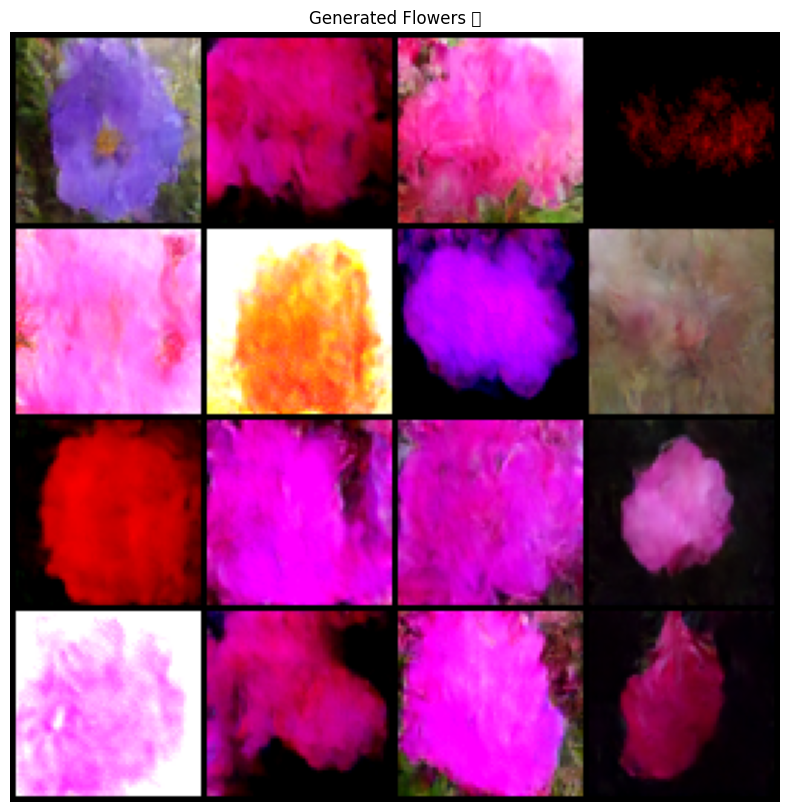

In [56]:
# Generate images
print("Starting image generation...")
generated_images = sample_images(n_samples=16, img_size=64)

# Visualize the generated images
show_images(generated_images, "Generated Flowers 🌸")

Generating and capturing intermediate steps...


100%|██████████| 1000/1000 [00:04<00:00, 208.12it/s]


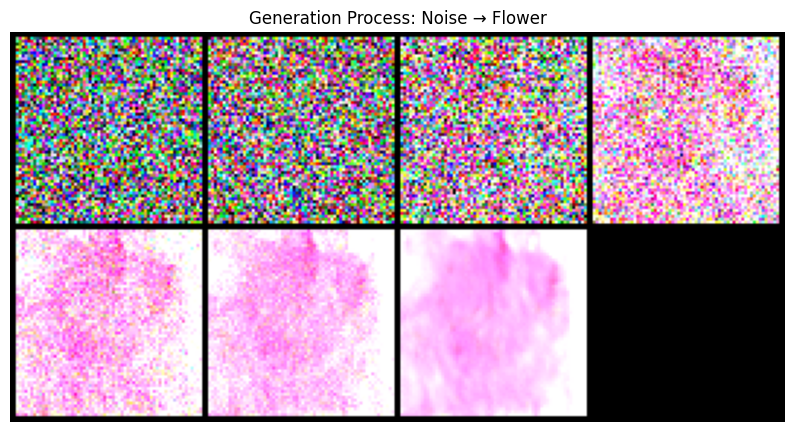

Timesteps shown: [999, 750, 500, 250, 100, 50, 0]


In [57]:
@torch.no_grad()
def visualize_generation_process():
    """
    Show how an image is generated step by step
    """
    model.eval()
    
    # Start from pure noise
    x = torch.randn(1, 3, 64, 64).to(device)
    
    # Timesteps to visualize
    timesteps_to_show = [999, 750, 500, 250, 100, 50, 0]
    images_at_timesteps = []
    
    print("Generating and capturing intermediate steps...")
    
    for t in tqdm(reversed(range(T)), total=T):
        t_batch = torch.full((1,), t, device=device, dtype=torch.long)
        x = sample_timestep(x, t_batch)
        
        # Save image at specific timesteps
        if t in timesteps_to_show:
            images_at_timesteps.append(x.cpu())
    
    # Concatenate and visualize
    images_at_timesteps = torch.cat(images_at_timesteps, dim=0)
    show_images(images_at_timesteps, "Generation Process: Noise → Flower")
    print(f"Timesteps shown: {timesteps_to_show}")

# Run the visualization
visualize_generation_process()